# Ready functions

In [306]:
from scipy.optimize import newton, brentq, broyden1
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from datetime import datetime
import pandas as pd
from IPython.display import display, HTML
from dateutil.relativedelta import relativedelta
from tenor_dates import TenorDates

In [415]:
vanilla_options = {"call" : 1, "put": -1}

# Forward price implied from outright contracts
def get_outright_forward_price(spot: float,
                               domestic_discount_factor: float, 
                               foreign_discount_factor: float) -> float:
    
    return spot*foreign_discount_factor/domestic_discount_factor

# Calculate BS d1 term
def get_bs_d1(forward_price:float,
              volatility: float,
              time_to_expiry: float,
              strike: float) -> float:
    return (np.log(forward_price/strike) + (volatility**2/2)*time_to_expiry)/(volatility*np.sqrt(time_to_expiry))

# Calculate BS d2 term
def get_bs_d2(forward_price:float,
              volatility: float,
              time_to_expiry: float,
              strike: float) -> float:
    return (np.log(forward_price/strike) - (volatility**2/2)*time_to_expiry)/(volatility*np.sqrt(time_to_expiry))

# Black-Scholes Option's Price
def get_bs_price(omega: int,
                 spot: float, 
                 volatility: float, 
                 time_to_expiry: float,
                 strike: float,
                 domestic_discount_factor: float, 
                 foreign_discount_factor: float) -> float:
    
    forward_price = get_outright_forward_price(spot = spot,
                                               domestic_discount_factor = domestic_discount_factor,
                                               foreign_discount_factor = foreign_discount_factor)
    d1 = get_bs_d1(forward_price = forward_price,
                   volatility = volatility,
                   time_to_expiry = time_to_expiry, 
                   strike = strike)
    d2 = get_bs_d2(forward_price = forward_price,
                   volatility = volatility,
                   time_to_expiry = time_to_expiry, 
                   strike = strike)
    
    return domestic_discount_factor*(omega*forward_price*norm.cdf(omega*d1) - omega*strike*norm.cdf(omega*d2))
    
# Calculate delta values (standard & Premium-included Delta)
def get_delta(omega: int, 
              spot: float, 
              volatility: float,
              time_to_expiry: float, 
              strike: float,
              domestic_discount_factor: float, 
              foreign_discount_factor: float, 
              delta_type: str) -> float:
    delta_type_li = ["st", "pi"]
    assert delta_type in delta_type_li, f"Unknown delta_type = {delta_type}! Supported delta_type: {delta_type_li}"
    
    forward_price = get_outright_forward_price(spot = spot,
                                               domestic_discount_factor = domestic_discount_factor,
                                               foreign_discount_factor = foreign_discount_factor)
    d1 = get_bs_d1(forward_price = forward_price,
                   volatility = volatility,
                   time_to_expiry = time_to_expiry, 
                   strike = strike)
    if delta_type == "st": # Standard Delta (in numeraire ccy)
        return omega*foreign_discount_factor*norm.cdf(omega*d1)
    elif delta_type == "pi": # Premium-included delta (in base ccy %)
        d2 = get_bs_d2(forward_price = forward_price,
                       volatility = volatility,
                       time_to_expiry = time_to_expiry, 
                       strike = strike)
        return omega*strike/spot*domestic_discount_factor*norm.cdf(omega*d2)

# Calculate Vega 
def get_vega(spot: float, 
              volatility: float,
              time_to_expiry: float, 
              strike: float,
              domestic_discount_factor: float, 
              foreign_discount_factor: float) -> float: 
    
    forward_price = get_outright_forward_price(spot = spot,
                                               domestic_discount_factor = domestic_discount_factor,
                                               foreign_discount_factor = foreign_discount_factor)
    d1 = get_bs_d1(forward_price = forward_price,
                   volatility = volatility,
                   time_to_expiry = time_to_expiry, 
                   strike = strike)
    
    return foreign_discount_factor*spot*norm.pdf(d1)*d1*np.sqrt(time_to_expiry)   
    
# Calculate Volga 
def get_volga(spot: float, 
              volatility: float,
              time_to_expiry: float, 
              strike: float,
              domestic_discount_factor: float, 
              foreign_discount_factor: float) -> float: 
    
    forward_price = get_outright_forward_price(spot = spot,
                                               domestic_discount_factor = domestic_discount_factor,
                                               foreign_discount_factor = foreign_discount_factor)
    d1 = get_bs_d1(forward_price = forward_price,
                   volatility = volatility,
                   time_to_expiry = time_to_expiry, 
                   strike = strike)
    d2 = get_bs_d2(forward_price = forward_price,
                   volatility = volatility,
                   time_to_expiry = time_to_expiry, 
                   strike = strike)
    
    return foreign_discount_factor*spot*norm.pdf(d1)*d1*d2*np.sqrt(time_to_expiry)/volatility


# Calculate Vanna
def get_vanna(spot: float, 
              volatility: float,
              time_to_expiry: float, 
              strike: float,
              domestic_discount_factor: float, 
              foreign_discount_factor: float) -> float: 
    
    forward_price = get_outright_forward_price(spot = spot,
                                               domestic_discount_factor = domestic_discount_factor,
                                               foreign_discount_factor = foreign_discount_factor)
    d1 = get_bs_d1(forward_price = forward_price,
                   volatility = volatility,
                   time_to_expiry = time_to_expiry, 
                   strike = strike)
    d2 = get_bs_d2(forward_price = forward_price,
                   volatility = volatility,
                   time_to_expiry = time_to_expiry, 
                   strike = strike)
    
    return -foreign_discount_factor*spot*norm.pdf(d1)*d2/volatility

# Calculate implied volatility from option price
def get_implied_vol_from_option_price(omega: int, 
                                      option_price: float, 
                                      spot: float, 
                                      strike: float,
                                      time_to_expiry: float, 
                                      domestic_discount_factor: float, 
                                      foreign_discount_factor: float) -> float:
    
    assert option_price >= 0, "Option price cannot be negative!"
    
    forward_price = get_outright_forward_price(spot = spot,
                                               domestic_discount_factor = domestic_discount_factor,
                                               foreign_discount_factor = foreign_discount_factor)
    # a starting point
    initial_vol = np.sqrt(2*forward_price/(time_to_expiry*strike))
    def to_solve(volatility: float) -> float:
        return option_price - get_bs_price(omega = omega,
                                           spot = spot, 
                                           volatility = volatility, 
                                           time_to_expiry = time_to_expiry,
                                           strike = strike,
                                           domestic_discount_factor = domestic_discount_factor, 
                                           foreign_discount_factor = foreign_discount_factor) 
#     # To find a, b such that f(a) x f(b) < 0
#     pct_diff = 0.1
#     a = (1 - pct_diff)*initial_vol
#     b = (1 + pct_diff)*initial_vol
#     n  = 0
#     while to_solve(a)*to_solve(b) >= 0:
#         n += 1
#         a = np.maximum((1 - pct_diff*n)*initial_vol, 0.01) # volatility cannot be negative
#         b = (1 + pct_diff*n)*initial_vol
    
#     return brentq(f = to_solve, a = a, b = b)
    # return broyden1(F = to_solve, xin = [0,0])
    return newton(func = to_solve, x0 = initial_vol, tol = 0.00001)


# Get strike from Delta (standard & premium-included) 
def get_strike_from_delta(omega: int,
                          spot: float,
                          volatility: float, 
                          time_to_expiry: float, 
                          domestic_discount_factor: float, 
                          foreign_discount_factor: float,
                          delta: float, 
                          premium_included: bool) -> float:
    
    assert isinstance(premium_included, bool),  "Argument 'premium_included' must be of bool type!"
    forward_price = get_outright_forward_price(spot = spot,
                                               domestic_discount_factor = domestic_discount_factor,
                                               foreign_discount_factor = foreign_discount_factor)
    if not premium_included: # standard Delta
        if (abs(delta) == 0.50) & (time_to_expiry <= 2):
            # Get ATM strike
            return forward_price*np.exp(0.5*volatility**2*time_to_expiry)
        elif (abs(delta) == 0.50) & (time_to_expiry > 2):
            return forward_price
        else:
            return forward_price*np.exp(-omega*volatility*np.sqrt(time_to_expiry)*norm.ppf(abs(delta)/foreign_discount_factor)\
                                    + 0.5*volatility**2*time_to_expiry)
    else: # premium-included Delta
        if (abs(delta) == 0.50) & (time_to_expiry <= 2):
            # Get ATM strike
            return forward_price*np.exp(-0.5*volatility**2*time_to_expiry)
        elif (abs(delta) == 0.50) & (time_to_expiry > 2):
            return forward_price
        else:
            # Set the initial strike = strike_from_st_delta 
            initial_strike = get_strike_from_delta(omega = omega, 
                                                   spot = spot, 
                                                   volatility = volatility, 
                                                   time_to_expiry = time_to_expiry, 
                                                   domestic_discount_factor = domestic_discount_factor, 
                                                   foreign_discount_factor = foreign_discount_factor, 
                                                   delta = delta, 
                                                   premium_included = False)
            # Create an objective function to be solved
            def to_solve(strike: float) -> float:

                return delta - abs(get_delta(omega = omega, 
                                             spot = spot, 
                                             volatility = volatility,
                                             time_to_expiry = time_to_expiry, 
                                             strike = strike,
                                             domestic_discount_factor = domestic_discount_factor, 
                                             foreign_discount_factor = foreign_discount_factor,
                                             delta_type = "pi"))


            return newton(func = to_solve, x0 = initial_strike, tol = 0.0001)


# Implied Volatility approximation
def get_implied_vol_approximation(strike : float, 
                                  input_strikes: list, 
                                  input_vols : list,
                                  spot : float,
                                  time_to_expiry : float,
                                  domestic_discount_factor : float,
                                  foreign_discount_factor : float,
                                  method : str) -> float:
    
    strike_25p, strike_atm, strike_25c = [input_strikes[i] for i in range(3)]
    vol_25p, vol_atm, vol_25c = [input_vols[i] for i in range(3)]
    assert strike_25p < strike_atm < strike_25c, f"Input strikes expected relationship: K_25p <  K_atm < K_25c, got: {input_strikes}"
    assert method in ["1st-order", "2nd-order"], f"Unknown method {method}"
    
    forward_price = get_outright_forward_price(spot = spot,
                                               domestic_discount_factor = domestic_discount_factor,
                                               foreign_discount_factor = foreign_discount_factor)
    
    d1_at_strike = get_bs_d1(forward_price = forward_price,
                             volatility = vol_atm,
                             time_to_expiry = time_to_expiry, 
                             strike = strike)
    d2_at_strike = get_bs_d2(forward_price = forward_price,
                             volatility = vol_atm,
                             time_to_expiry = time_to_expiry, 
                             strike = strike)
    d1_at_strike_25p = get_bs_d1(forward_price = forward_price,
                               volatility = vol_25p,
                               time_to_expiry = time_to_expiry, 
                               strike = strike_25p)
    d2_at_strike_25p = get_bs_d2(forward_price = forward_price,
                               volatility = vol_25p,
                               time_to_expiry = time_to_expiry, 
                               strike = strike_25p)
    d1_at_strike_25c = get_bs_d1(forward_price = forward_price,
                               volatility = vol_25c,
                               time_to_expiry = time_to_expiry, 
                               strike = strike_25c)
    d2_at_strike_25c = get_bs_d2(forward_price = forward_price,
                               volatility = vol_25c,
                               time_to_expiry = time_to_expiry, 
                               strike = strike_25c)

    # First order approximation
    zeta_1 = (np.log(strike_atm/strike)*np.log(strike_25c/strike))/(np.log(strike_atm/strike_25p)*np.log(strike_25c/strike_25p))*vol_25p + \
             (np.log(strike/strike_25p)*np.log(strike_25c/strike))/(np.log(strike_atm/strike_25p)*np.log(strike_25c/strike_atm))*vol_atm + \
             (np.log(strike/strike_25p)*np.log(strike/strike_atm))/(np.log(strike_25c/strike_25p)*np.log(strike_25c/strike_atm))*vol_25c
    # Second order approximation
    big_d1 = zeta_1 - vol_atm
    big_d2 = (np.log(strike_atm/strike)*np.log(strike_25c/strike))/(np.log(strike_atm/strike_25p)*np.log(strike_25c/strike_25p)) * \
            d1_at_strike_25p * d2_at_strike_25p * (vol_25p - vol_atm)**2 + \
            (np.log(strike/strike_25p)*np.log(strike/strike_atm))/(np.log(strike_25c/strike_25p)*np.log(strike_25c/strike_atm)) * \
            d1_at_strike_25c * d2_at_strike_25c * (vol_25c - vol_atm)**2 
    
    radicand = vol_atm**2 + d1_at_strike*d2_at_strike*(2*vol_atm*big_d1 + big_d2)
    
    
    assert np.all(radicand >= 0), "radicand cannot be negative!"

    zeta_2 = vol_atm + (-vol_atm + np.sqrt(radicand))/(d1_at_strike*d2_at_strike)
    
    if method == "1st-order":
        return zeta_1
    elif method == "2nd-order":
        return zeta_2
    
    
def get_equiv_vwb_from_market_vwb(spot: float, 
                                  vol_atm: float, 
                                  rr: float, 
                                  market_vwb: float,
                                  time_to_expiry: float,
                                  domestic_discount_factor: float, 
                                  foreign_discount_factor: float) -> float:
    
    # 1. Calculate the conventional volatility for the 25D VWB and ATM strike
    vol_vwb = vol_atm + market_vwb # vol_vwb does not change 
    strike_atm = get_strike_from_delta(omega = -1,
                                       spot = spot,
                                       volatility = vol_atm, 
                                       time_to_expiry = time_to_expiry, 
                                       domestic_discount_factor = domestic_discount_factor, 
                                       foreign_discount_factor = foreign_discount_factor,
                                       delta = 0.50, premium_included = True)

    # 2. Retrieve the two 25D volatilities in a "consistent" way
    vwb_e = market_vwb # first iteration i = 0
    vwb_e_diff = 0.0001
    i = 0
    while True:
        vol_25p = vol_atm + vwb_e - 0.5*rr
        vol_25c = vol_atm + vwb_e + 0.5*rr

        # 3. Calculate the 25D strikes with the "consistent" volatilities
        strike_25p = get_strike_from_delta(omega = -1,
                                           spot = spot,
                                           volatility = vol_25p, 
                                           time_to_expiry = time_to_expiry, 
                                           domestic_discount_factor = domestic_discount_factor, 
                                           foreign_discount_factor = foreign_discount_factor,
                                           delta = 0.25, 
                                           premium_included = True)

        strike_25c = get_strike_from_delta(omega = 1,
                                           spot = spot,
                                           volatility = vol_25c, 
                                           time_to_expiry = time_to_expiry, 
                                           domestic_discount_factor = domestic_discount_factor, 
                                           foreign_discount_factor = foreign_discount_factor,
                                           delta = 0.25, 
                                           premium_included = True)

        # 4. Calculate the 25D strikes for the market VWB
        vwb_strike_25p = get_strike_from_delta(omega = -1,
                                               spot = spot,
                                               volatility = vol_vwb, 
                                               time_to_expiry = time_to_expiry, 
                                               domestic_discount_factor = domestic_discount_factor, 
                                               foreign_discount_factor = foreign_discount_factor,
                                               delta = 0.25, 
                                               premium_included = True)

        vwb_strike_25c = get_strike_from_delta(omega = 1,
                                               spot = spot,
                                               volatility = vol_vwb, 
                                               time_to_expiry = time_to_expiry, 
                                               domestic_discount_factor = domestic_discount_factor, 
                                               foreign_discount_factor = foreign_discount_factor,
                                               delta = 0.25, 
                                               premium_included = True)

        # 5. Calculate the difference between VWB STGL and conventional STGL
        strike_25p = strike_25p
        strike_atm = get_strike_from_delta(omega = -1,
                                           spot = spot,
                                           volatility = vol_atm, 
                                           time_to_expiry = time_to_expiry, 
                                           domestic_discount_factor = domestic_discount_factor, 
                                           foreign_discount_factor = foreign_discount_factor, 
                                           delta = 0.5, 
                                           premium_included = True)
        strike_25c = strike_25c
        input_strikes = [strike_25p, strike_atm, strike_25c]

        vol_25p = vol_25p
        vol_atm = vol_atm
        vol_25c = vol_25c
        input_vols = [vol_25p, vol_atm, vol_25c]

        vol_25p_from_vol_surface = get_implied_vol_approximation(strike = vwb_strike_25p, 
                                                                 input_strikes = input_strikes, 
                                                                 input_vols = input_vols, 
                                                                 spot = spot,
                                                                 time_to_expiry = time_to_expiry,
                                                                 domestic_discount_factor = domestic_discount_factor,
                                                                 foreign_discount_factor = foreign_discount_factor, 
                                                                 method = "2nd-order") 

        vol_25c_from_vol_surface = get_implied_vol_approximation(strike = vwb_strike_25c, 
                                                                 input_strikes = input_strikes, 
                                                                 input_vols = input_vols, 
                                                                 spot = spot,
                                                                 time_to_expiry = time_to_expiry,
                                                                 domestic_discount_factor = domestic_discount_factor,
                                                                 foreign_discount_factor = foreign_discount_factor, 
                                                                 method = "2nd-order") 

        call_25_iv = get_bs_price(omega = 1,
                                 spot = spot, 
                                 volatility = vol_25c_from_vol_surface,
                                 time_to_expiry = time_to_expiry,
                                 strike = vwb_strike_25c,
                                 domestic_discount_factor = domestic_discount_factor, 
                                 foreign_discount_factor = foreign_discount_factor)

        put_25_iv = get_bs_price(omega = -1,
                                 spot = spot, 
                                 volatility = vol_25p_from_vol_surface, 
                                 time_to_expiry = time_to_expiry,
                                 strike = vwb_strike_25p,
                                 domestic_discount_factor = domestic_discount_factor, 
                                 foreign_discount_factor = foreign_discount_factor)

        call_25_market_vwb = get_bs_price(omega = 1,
                                 spot = spot, 
                                 volatility = vol_vwb, 
                                 time_to_expiry = time_to_expiry,
                                 strike = vwb_strike_25c,
                                 domestic_discount_factor = domestic_discount_factor, 
                                 foreign_discount_factor = foreign_discount_factor)

        put_25_market_vwb = get_bs_price(omega = -1,
                                 spot = spot, 
                                 volatility = vol_vwb, 
                                 time_to_expiry = time_to_expiry,
                                 strike = vwb_strike_25p,
                                 domestic_discount_factor = domestic_discount_factor, 
                                 foreign_discount_factor = foreign_discount_factor)

        # 6. Calculate the numerical derivatives of the quantity S after i = 0
        S = (call_25_iv + put_25_iv) - (call_25_market_vwb + put_25_market_vwb)
        if i == 0:
            prev_S = S
            vwb_e += vwb_e_diff
            i += 1
        else:
            d_S = S - prev_S
            prev_S = S
            
            if abs(d_S) < 0.0001:
                return vwb_e
            
            dS_dvwb = d_S/vwb_e_diff # derivative of S wrt vwb
            vwb_e_diff = -S/dS_dvwb

            # 7. Update new vwb
            vwb_e += vwb_e_diff
            i += 1

# The FX Market

XXXYYY currency pair
- XXX is called the foreign / base currency
- YYY is called the numeraire / domestic currency

## Outright contracts
- Two counterparties enter into an outright (or forward) contract agree to exchange at a given expiry date, the base currency amounts against a numeraire currency amount equal to the forward exchange rate.
- FX forward price:
\begin{align*}
F(t,T) = S_t \frac{P^f(t,T)}{P^d(t,T)}
\end{align*}
- In the market, **outright contracts are quoted in forward points**:
\begin{align*}
Fpts(t,T) = F(t,T) - S_t
\end{align*}
Foward points can be positive or negative, depending on the interest rate differentials, and are also a function of the level of the spot rate. To get the fair forward FX rate, we add the forward points to the spot rate. 

## FX Swap
- The FX swap is a very popular contract involving a spot and an outright (forward) contract.
- Two counterparties entering into an FX swap contract agree to close a spot deal for a given amount of the base currency, and at the same time they agree to reverse the trade by an outright (forward) with the same base currency amount at a given expiry.
- FX swap valuation is the sum of a spot contract and the value of a forward contract. They are added to the spot rate when an outright is traded to get the fair Forward FX rate. So we just need the spot rate and the forward points.
- The quoted price of an FX swap will simply be the **forward points**.

### Summary for Outright and FX Swap contracts:
1. An outright contract is exposed to an FX rate risk for the full nominal amount and has exposure to interest rates albeit smaller than FX risk.
1. For FX swap contract, the FX risk of the spot transaction is entirely offset by the outright transaction. In the case of non-par (uneven) contracts, the FX risk is completely offset, and only a residual exposure to the interest rate risk is left.
1. The FX swap is rather a treasury product, traded in the interbank market to move funds from one currency to another, without any FX risk (par contracts), and to hedge or get exposure to the interest rate risks in two different currnecies. Nonetheless, it is used by options traders to hedge exposure to the domestic and foreign interest rates.

### Effect of Default on Forward price
1. The forward rate does not identify the unique arbitrage-free price of an outright contract, if we include the chance of default of the counterparty.
1. The forward price implied by an FX swap contract can be different from that of an outright contract when default of the counterparty is considered. FX swap is less risky than an outright contract.


## FX Options

### Premium
The option's premium is paid on the spot settlement date. It can be expressed in 4 different ways:
1. Numeraire currency units (pips). This is the standard / natural premium one calculates by a pricing formula. The actual premium to pay is calculated by multiplying the currency units with the notional amount: $N_{\text{CCY1}} \times \text{CCY2}_{\text{pips}}$
1. Numeraire currency percentage. This is the standard way for exotic options, when the payout is a numeraire currency amount. It can be calculated by dividing the premium in numeraire currency units by the strike. The actual premium to pay is equal to the notional amount in numeraire currency units times the numeraire currency percentage premium. 
1. Base currency units (pips). This way of quoting may be useful when the numeraire currency amount is fixed for all the options entering into a given strategy (eg. a call spread). It can be calculated by dividing the premium in numeraire currency units by the spot FX rate then by the strike. The actual premium to pay is equal to the notional amount times the base currency units premium.
1. Base currency percentage. This is the standard way in which premiums are quoted for barrier options and for some pairs / some vanilla options. It can be calculated by dividing the premium in numeraire currency units by the spot FX rate. The actual premium to pay is equal to the notional amount times the base currency percentage premium.

<figure>
    <img src="images/fx_option_premium_market_convention.png" width="500"/>
    <figcaption>Fig.1 - Market conventions for option premiums for some pairs.</figcaption>
</figure>

### Market standard practices for quoting options
1. Options are quoted for standard dates: ON, 1W, 2W, 1M, 2M, 3M, 6M, 1Y, 2Y.
1. Quotations are not in terms of premiums but are in terms of implied volatilities.
1. Strike prices are quoted in terms of Delta of the option: Strike level is not determined yet in absolute terms when trading.
1. If not otherwise specified, the option is considered to be traded Delta-hedged, i.e., a spot trade offsetting the BS Delta exposure is closed along the option's transaction.
1. For barrier options, barrier levels are asked for in absolute terms, by specifying the reference spot FX rate and also an ATM implied volatility level. The quote will be provided in terms of the premium as a percentage of the base currency notional. Also, it is assumed that the deal includes a Delta-hedged transaction and in most cases a Vega-hedged transaction


### Mainly Traded FX Option Structures
#### ATM Straddle (STDL)
- A sum of a call and a put struck at the ATM level. The quotes for this structure on standard expiries are the most liquid ones.
- By definition, no $\Delta$ hedge will be exchanged since it generate no exposure to the FX rate.
- Several ATM definition exist: ATM-spot (strike = spot), ATM-forward (strike = forward), 0-$\Delta$ STDL (strike is chosen such that call and put have the same $\Delta$ but different sign, implies no $\Delta$ hedge is needed)
- The ATM implied volatility quoted in the FX option market is the **0-$\Delta$ STDL strike**. It is the implied volatility to plug into the BS formula when trading an ATM STDL.

#### Risk Reversal (25% $\Delta$ RR)
- Buy a call and sell a put with a symmetric $\Delta$ (long RR) or the reverse (short RR). 
- $\Delta$ can be chosen to be any level, with 25% being the most liquid one so that the call and the put entering into the RR will have a strike level yielding 25% $\Delta$
- The RR is quoted as the difference between the two implied volatilities to plug into the BS formula in order to price two legs of the structure.
$$
rr(t, T; 25) = \sigma_{25C}(t,T) - \sigma_{25P}(t,T)
$$
- The RR amount is typically denominated in terms of base currency units.

#### Vega-weighted Butterfly (25% $\Delta$ VWB)
- Sell an ATM STDL and buy a symmetric Delta strangle (sum of a call and a put).
- 25% is the most liquid one.
- This structure is vega-weighted and since the Vega of the straddle is greater than the Vega of the strangle, the quantity of the former has to be smaller. The amount on the strangle will be calculated so that the total Vega of the structure is nil. 
$$
\text{vmb}(t, T; 25) = 0.5[\sigma_{25C}(t,T) + \sigma_{25P}(t,T)] - \sigma_{ATM}(t,T)
$$
- The VMB amount is expressed in terms of base currency units and is referred to the amount of the ATM STDL.




# Pricing Models for FX Options
## Principles of Option Pricing Theory
The value of a European contingent claim that can be replicated via an admissible strategy is give by  the risk-neutral expectation of the terminal value:
\begin{align}
\mathcal{O}_t = D^d_tE^Q[(D^d_T)^{-1}\mathcal{O}_T | \mathcal{F}_t]
\label{eq:risk_neutral_expectation}
\end{align}

The risk-neutral evolution of the FX rate process:
\begin{align}
dS_t = (r^d_t - r^f_t)S_t dt + \zeta_t S_t dW^Q_t
\label{eq:risk_neutral_fx_process}
\end{align}
### Black Scholes Economy
- An FX pair can be considered as an asset yielding a continuous cash flow equal to the foreign interest rate.
- A self-financing strategy is a strategy where the change in portfolio value is entirely due to trading gains/losses rather than the addition/withdrawal of cash.
- The solution to the PDE can be expressed in terms of an expectation by the means of Feynman-Kac formula. The process commanding the dynamics for $S$ is not the original one but the risk-neutral one. The expectation has shifted from the real-world probability measure to a risk-neutral probability. 
- The benefit is that one does not need to worry about the actual drift of the asset and can safely determine it with quantities easily retrievable from market data, such as interest rates.
- Once the solution is obtained, the next step is to calculate an equivalent martingale measure for the FX rate.

To recapitulate:
1. There is a connection between the existence of a self-financing strategy, replicating the final value of the contingent claim, and the existence of an equivcalent martingale measure.
1. An arbitrage-free price of the contingent claim can be unequivocally determined.
1. The price can be calculated as the current value of the related replica strategy, or alternatively as the expected value of the discounted final payoff of the claim under the risk-neutral probability measure.


### Stochastic Volatility Economy
- The replication argument via the self-financing strategy cannot be applied and the market is defined as incomplete. A consequence of the market incompleteness is that there is no unique equivalent martingale measure under which an arbitrage-free price can be calculated.
- One possible approach to make up for this situation is to assume that an equivalent probability measure exist under which the discounted price is a martingale for some time.
- We can derive the PDE whose soluation, provided suitable terminal and boundary conditions are met, is the price of the contingent claim in a stochastic volatility world.
- The main point here is to find an equivalent probability measure under which the discounted price of the FX rate is a martingale.

### Change of Numeraire
- A numeraire can be any traded (non-dividend-paying) asset, and it can be used to normalize the prices of all other assets and contingent claims.
- The theory of change of numeraire is particularly useful in the interest rate derivatives' evaluation, but it turns out that we will occasionally resort to it. The results in Brigo and Mercurio is a simple and powerful tool that can be employed when it is more convenient to change the numeraire to allow for a less painful achievement of a pricing formula.


## Black-Scholes model
- Under BS framework, vanilla option price:
\begin{align}
\mathcal{O}(S_t, t) &= P^{d}(t,T)[\omega F(t,T)\Phi(\omega d_1) - \omega K \Phi(\omega d_2)]
\label{eq:BSM}
\end{align}

where 
\begin{align*}
d_1 &= \frac{\ln \frac{F(t, T)}{K} + \frac{\sigma^2}{2}(T-t)}{\sigma \sqrt{T-t}}\\
d_2 &= d_1 - \sigma \sqrt{T-t} \\
&= \frac{\ln \frac{F(t, T)}{K} - \frac{\sigma^2}{2}(T-t)}{\sigma \sqrt{T-t}}\\
P^n(t,T) &= \frac{D^n_t}{D^n_T}, n \in \{d, f\} ~ \text{is the price of pure zero-coupon bond}  \\
\omega &= 
\begin{cases}
      1 & \text{for call option}\\
      -1 & \text{for put option}\\
    \end{cases}  
\end{align*}
- Implied volatility $\sigma$ is important because it is a tool to express options' market prices.
- The BS formula is monotone in $\sigma$.
- Although the BS model suffers many flaws, it is still often used, at least for quoting purposes. Some practical usage of BS:
    1. In the FX options market, option prices are quoted in terms fo implied volatilities. 
    1. The Delta hedge to be exchanged is calculated according to the BS formula
    1. The Vega hedge for exotic options.
    1. To run trading books.
    
### The forward price to use in the formula
- When default risk is considered, the forward prices implied by the FX swap prices can be (significantly) different from those implied by the outright contracts. 
- An FX swap contract can actually be considered as a collateralised loan, by either party, so we can expect the interest rates to set the forward price will be different from those to set the forward price of an outright contract. This reflects the specific lower risk borne for default in an FX swap contract.
- In the BS pricing formula above, we have to use the forward price implied by the FX swap contract, since we can use them for hedging purposes. 
- Here we outline a method to include the default risk in the analysis and determine the "pure" interest rates and then those related to the FX swap contracts. We assume:
    - All market participants have the same probability of defaul in a given period of time, starting from $t$ and ending at $T$.
    - The loss $L_{\{.\}}$ borne on the notional amount of the contract is the same for each counterparty, so the recovery rate is $R_{\{.\}} = 1 - L_{\{.\}}$ and depends on the currency the notional is denominated in. 
- The fair forward price of an FX swap starting at $t$ and expiring at $T$ is the sum of one unit of foreign currency today, plus the expected value at time $T$ of one unit of foreign currency discounted at the risk-free rate. The expected value at $T$ is in square brackets and is equal to one, weighted by the survival probability, plus the recovery received if the counterparty goes bankrupt, weighted by the default probability:
\begin{align*}
\text{Fsw}^f(t,T) &= 1 - P^f_{r_f}(t,T)[1 ~ Q(t,T) + R_f(1- Q(t,T))]
\end{align*}
where
\begin{align*}
&Q(t,T) = \mathop{\mathbb{E}}[1_{\tau_t > T} | \mathcal{F}_t] ~ \text{is the survival probability of the generic counterparty at time $t$ up to time $T$} \\
&R_f = 1 - L_f ~ \text{is the recovery rate denominated in foreign currency}
\end{align*}
The domestic currency leg's present value is similarly derived:
\begin{align*}
\text{Fsw}^d(t,T) &= -S_t + F(t,T)P^d_{r_f}(t,T)[1 ~ Q(t,T) + R_d(1- Q(t,T))]
\end{align*}
- The net present value in domestic currency units at time $t$ is:
\begin{align*}
\text{Fsw}(t,T) =& S_t \times \text{Fsw}^f(t,T) + \text{Fsw}^d(t,T)\\
=& S_t \big(1 - P^f_{r_f}(t,T)[1 ~ Q(t,T) + R_f(1- Q(t,T))] \big) \\
&-S_t + F(t,T)P^d_{r_f}(t,T)[1 ~ Q(t,T) + R_d(1- Q(t,T))]
\end{align*}
By setting it equals to zero, we have that the forward price of an FX swap contract is:
\begin{align}
F(t, T) = S_t \frac{P^f_{r_f}(t, T)[1 Q(t,T) + R_f(1-Q(t,T))]}{P^d_{r_f}(t, T)[1 Q(t,T) + R_d(1-Q(t,T))]}
\label{eq:swap_forward_price}
\end{align}

- Some conclusions can be drawn from equation \ref{eq:swap_forward_price}:
    1. If the recovery rates $R_f = R_d \Rightarrow$ forward price $=$ price of pure zero-coupon bonds.
    1. The risk-free zero-coupon bonds ($P^d_{r_f}$ & $P^f_{r_f}$) can be computed by means of the OIS (overnight indexed swaps) swap rates.
    
- We can apply the following rules to identify the inputs (forward price and discounting) of formula \ref{eq:BSM}:
    1. The forward price is that calculated in \ref{eq:swap_forward_price} and implied from FX swap prices.
    1. The discounting is performed with the zero-coupon prices $P^d(t,T)$ based on the Euribor rates. Here we are assuming that the default risk borne by the buyer of the option is the same as that for the buyer of a deposit in the interbank market.
    1. In the case when the default risk is not the same as that of a deposit, we can substitute $P^d$ with $P^d_{r_f}(t,T)$ (which is extracted from the OIS swap prices).
    
### BS Greeks

#### Delta
- The first derivative of the option price with respect to the underlying FX spot rate (**in $p_{numccy}$**):
\begin{align}
\Delta(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, \omega) = \Delta_t = \frac{\partial Bl}{\partial S_t} = \omega P^f(t,T) \Phi(\omega d_1)
\end{align}
    - Mathematically: Delta is the ratio of the variation of option price to an infinitesimal variation of the FX spot rate.
    - Financially: Delta is the amount of base currency units, expressed as a percentage of the notional (base currency), equivalent to the position in the option. It determines the amount of the base currency in the hedge FX spot transaction.
- For pairs with premiums quoted **in $p_{baseccy\%}$**, let $S^\prime = \frac{1}{S}$. The Delta w.r.t. $S^\prime$ is then 
\begin{align*}
\frac{\partial(0.01 p_{baseccy\%})}{\partial S^\prime_t} = \frac{\partial[Bl(\frac{1}{S^\prime_t}) S^\prime_t]}{\partial S^\prime_t} = - \Delta_t \frac{1}{S^{\prime2}_t}S^{\prime}_t + Bl(\frac{1}{S^\prime_t}) = -\frac{\Delta}{S^\prime_t} + Bl(\frac{1}{S^{\prime}_t})
\end{align*}
It represents the amount the trader has to hold in numeraire currency units to hedge the options value, $0.01p_{baseccy\%}$. When trading the option, it is market convention to express the spot hedge transaction as a percentage of the base currency notional, so that when we convert the amount above into base currency we yield:
\begin{align}
\Delta_t^{pi} = -\frac{1}{S_t}\big[-\frac{\Delta_t}{S^\prime_t} + Bl\big(\frac{1}{S^\prime} \big)\big] = \Delta_t - \frac{Bl(\frac{1}{S^\prime_t})}{S_t} = \Delta_t - 0.01p_{baseccy\%}
\end{align}
This is called the *premium-included Delta* and can be re-written more explicitly as:
\begin{align}
\Delta_t^{pi} = \omega \frac{K}{S_t}P^d(t,T)\Phi(\omega d_2)
\end{align}
The *premium-included Delta* is used amongst professionals when the premium is expressed as $p_{baseccy\%}$ to determine the amount of the hedge spot transaction.
- In summary, apart from the market standards, in running of the book the two different kinds of Delta can be used according to the actual hedging targets of the traders. For EURUSD, US-based trader will hedge by the standard Delta's indications (USD is numeraire ccy), whereas the Europe-based trader will hedge the premium-adjusted Delta's suggestions. 


#### Gamma
- Gamma is the second derivative of the option's price w.r.t. the underlying price. It is used to gauge how much Delta would change according to the FX rate. 
\begin{align}
\Gamma(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, \omega) = \Gamma_t = \frac{\partial^2 Bl}{\partial S_t^2} = \frac{\omega P^f(t,T)\phi(d_1)}{S_t \sigma \sqrt{T-t}}
\end{align}
with
\begin{align*}
\phi(x) = \Phi^\prime (x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}
\end{align*}
- If the Delta is premium included, then Gamma is
\begin{align}
\Gamma^{pi}(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, \omega) =& \Gamma(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, \omega) \\
&- \frac{\Delta(S_t,t,T,K,P^d(t,T), P^f(t,T), \sigma, \omega)}{S_t} + 2 \frac{0.01 p_{baseccy\%}}{S_t}
\end{align}
- Usually, it is expressed so as to indicate how much Delta changes given a variation of the FX spot rate, this will be taken equal to $1\%$ typically. This is also called the *trader's Gamma*.
\begin{align}
\Gamma^{tr}_t = \Gamma_t \frac{S_t}{100}
\end{align}
- Delta and Gamma are tools to hedge exposure to FX rate changes.

#### Vega
- The main source of risk comes from volatility. In BS model, it assumes volatility to be flat / deterministic function of time.
\begin{align}
\mathcal{V}(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, \omega) &= \mathcal{V}_t = \frac{\partial Bl}{\partial \sigma} = P^f(t,T)S_t\sqrt{T-t}\phi(d_1)
\end{align}

#### Volga
- Volga is used to estimate the stability of trader's hedge on implied volatility, i.e., the derivative of Vega with respect to the implied volatility.
\begin{align}
\mathcal{W}(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, \omega) &= \mathcal{W}_t = \frac{\partial^2 Bl}{\partial \sigma^2} = \frac{P^f(t,T)S_t \phi(d_1)d_1 d_2\sqrt{T-t}}{\sigma}
\end{align}
- Volga is analogous to Gamma for the volatility (volatility Gamma).

#### Vanna
- Vanna measures the sensitivity of Vega w.r.t. the FX spot rate.
\begin{align}
\mathcal{X}(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, \omega) &= \mathcal{X}_t = \frac{\partial^2 Bl}{\partial \sigma \partial S_t} = -\frac{P^f(t,T)S_t \phi(d_1) d_2}{\sigma}
\end{align}
- When premium is included in Delta, Vanna is modified as follows:
\begin{align}
\mathcal{X}^{pi}(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, \omega) &= \mathcal{X}(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, \omega) - \frac{\mathcal{V}(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, \omega)}{S_t}
\end{align}

#### Rho
- These two sensitivities are momentous for risk management: the domestic and foreign Rhos:
\begin{align}
\text{Rho}^d(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, \omega) &= \text{Rho}^d_t = \frac{\partial Bl_t}{\partial \bar{r}^d} = \omega K (T-t) P^d(t,T)\Phi(\omega d_2) \\
\text{Rho}^f(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, \omega) &= \text{Rho}^f_t = \frac{\partial Bl_t}{\partial \bar{r}^f} = -\omega S_t (T-t) P^f(t,T)\Phi(\omega d_1)
\end{align}
- It is worth noting that the average interest rate $\bar{r}^c = \frac{\int^T_t r^c_s ds}{(T-t)}$ with $c \in \{d, f \}$

### Retrieving implied volatility and strike
- The BS formula is used as a benchmark in the market to calculate plain vanilla options' price and to some extent also in trading barrier options.
- To calculate volatility ($\sigma$) for a given option premium, a numerical procedure (Newton-Raphson method) must be employed to back it out. A good starting point:
\begin{align*}
\sigma = \sqrt{\frac{2}{T- t} \frac{F(t,T)}{K}}
\end{align*}
An alternative starting point:

- To calculate strike ($K$) from a given **standard Delta**:
\begin{align}
K = F(t,T) \exp \bigg[-\omega \sigma \sqrt{T-t} \Phi^{-1}\bigg(\frac{|\Delta|}{P^f(t,T)} \bigg) + \frac{1}{2} \sigma^2 (T-t)\bigg]
\label{eq:strike_from_st_delta}
\end{align}
- To calculate strike from a given **premium-included Delta**, we have to resort to numerical methods (Newton-Raphson), we can use equation \ref{eq:strike_from_st_delta} as initial value.

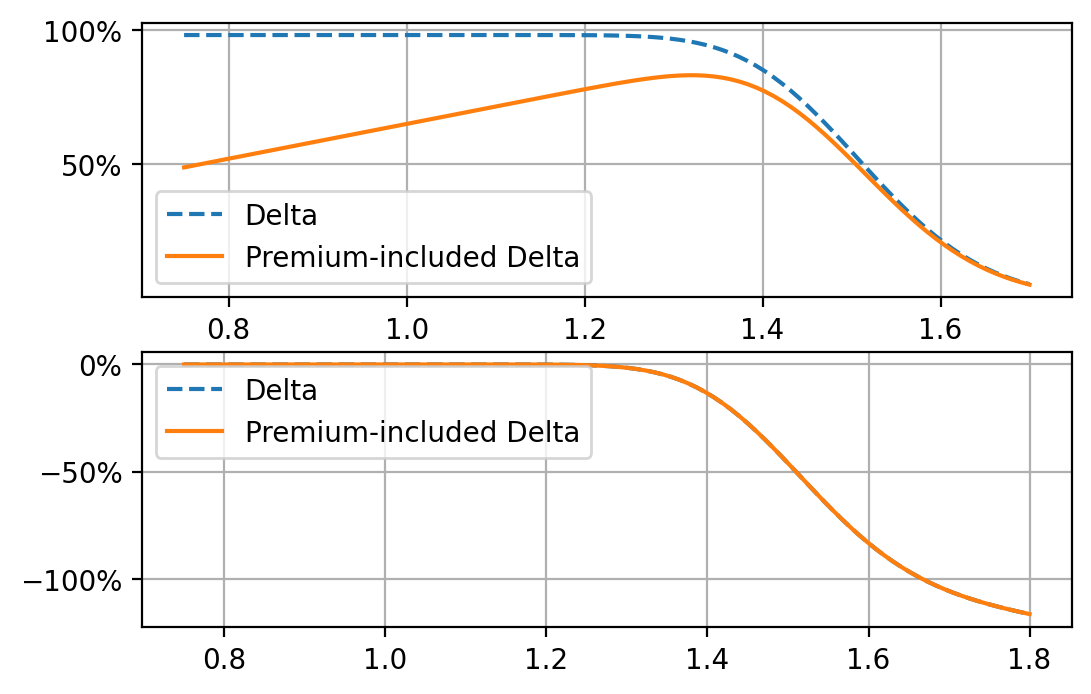

In [435]:
strikes = np.linspace(0.75, 1.70, 100)
res1 = []
res2 = []
for k in strikes:
    res1.append(get_delta(omega = 1, 
                          spot = 1.5000, 
                          volatility = 10/100,
                          time_to_expiry = 0.5, 
                          strike = k,
                          domestic_discount_factor = 0.97531, 
                          foreign_discount_factor = 0.98265, 
                          delta_type = "st")* 100)

    res2.append(get_delta(omega = 1, 
                          spot = 1.5000, 
                          volatility = 10/100,
                          time_to_expiry = 0.5, 
                          strike = k,
                          domestic_discount_factor = 0.97531, 
                          foreign_discount_factor = 0.98265, 
                          delta_type = "pi")*100)
    
fig, ax = plt.subplots(2,1, dpi = 200)
ax[0].plot(strikes, res1, linestyle = "--", label = "Delta")
ax[0].plot(strikes, res2, label = "Premium-included Delta")
ax[0].legend()
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[0].grid()
strikes = np.linspace(0.75, 1.80, 100)
res1 = []
res2 = []
for k in strikes:
    res1.append(get_delta(omega = -1, 
                          spot = 1.5000, 
                          volatility = 10/100,
                          time_to_expiry = 0.5, 
                          strike = k,
                          domestic_discount_factor = 0.97531, 
                          foreign_discount_factor = 0.98265, 
                          delta_type = "pi")*100)

    res2.append(get_delta(omega = -1, 
                          spot = 1.5000, 
                          volatility = 10/100,
                          time_to_expiry = 0.5, 
                          strike = k,
                          domestic_discount_factor = 0.97531, 
                          foreign_discount_factor = 0.98265, 
                          delta_type = "pi")*100)
    
ax[1].plot(strikes, res1, linestyle = "--", label = "Delta")
ax[1].plot(strikes, res2, label = "Premium-included Delta")
ax[1].legend()
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].grid()
plt.show()

From the first plot we can see the function is not monotonic. Some levels of the premium-included Delta can be produced by two strikes. This could be an issue when we run a numerical scheme, it may converge to one of two possible solutions.

### Some BS formula Relationships
#### Put -call parity
- A model independent relationship, can be proved by a no-arbitrage argument.
\begin{align}
C(K,T) - P(K,T) = S_tP^f(t,T) - KP^d(t,T)
\end{align}

#### Put-call symmetry
\begin{align*}
Bl(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, 1) = Bl(K, t, T, S_t, P^f(t,T), P^d(t,T), \sigma, -1)
\end{align*}
- Could be useful:
    - derive pricing formula of particular kinds of options
    - to hedge knock-in options   
- A more practical version:
\begin{align}
Bl(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, 1) = \frac{K}{S_t}Bl(S_t, t, T, \frac{S_t^2}{K}, P^f(t,T), P^d(t,T), \sigma, -1)
\end{align}
The reason: It is possible (not easy) to trade an option struck at $S_t^2/K$ in an amount $(K/S_t)$ with an FX spot rate equal to $S_t$, whereas it would be also impossible to trade it with the FX spot set equal to $K$.

#### Foreign-domestic symmetry 
- An application of the put-call symmetry, specific to the FX options market:
\begin{align}
\frac{1}{S_t}Bl(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, 1) = K Bl(\frac{1}{S_t}, t, T, \frac{1}{K}, P^f(t,T), P^d(t,T), \sigma, -1)
\end{align}
- Financial interpretation: Two traders from different countries trading the same option must agree on the value, even if one considers the FX rate from their own prospective.

#### Other Useful Properties / Relationships
1. BS formula is time-homogeneous, meaning it only depends on the time to maturity.
1. If replace $\bar{r}^d$, $\bar{r}^f$, $\sigma$ and $\tau$ with $\bar{r}^d \phi$, $\bar{r}^f \phi$, $\sigma \sqrt{\phi}$ and $\tau/\phi$ where $\phi$ is a strictly positive number, the option price does not change:
\begin{align}
Bl(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, \omega) = Bl(S_t, \frac{t}{\phi}, \frac{T}{\phi}, K, P^f(t,T; \phi), P^d(t,T; \phi), \sigma \sqrt{\phi}, \omega)
\end{align}
where $P^c(t,T;\phi)= e^{-\bar{r}^c(T-t)/\phi}$, for $c \in \{d, f\}$
1. Interest rate symmetry:
\begin{align}
\frac{\partial Bl}{\partial \bar{r}^d} + \frac{\partial Bl}{\partial \bar{r}^f} + \tau Bl = 0
\end{align}
1. Vega-Gamma relationship:
\begin{align}
\frac{1}{2}\sigma\frac{\partial Bl}{\partial \sigma} = \frac{\tau}{2}\frac{\partial^2 Bl(S_t, t)}{\partial S^2_t}\sigma^2 S^2_t + (\bar{r}^d - \bar{r}^f)\bigg[\tau S_t \frac{\partial Bl}{\partial S_t} + \frac{\partial Bl}{\partial \bar{r}^f} \bigg] 
\end{align}
This relationship also holds for any claim with a path-dependent payoff (e.g., barrier options) as long as the interestes rates and the volatility are constant. A further simplification for European payoff claims is possible:
\begin{align}
\frac{1}{2}\sigma \frac{\partial Bl}{\partial \sigma} = \frac{\tau}{2}\frac{\partial^2 Bl(S_t, t)}{\partial S^2_t}\sigma^2 S^2_t
\end{align}
1. Delta-Vega relationship: A call and a put option expiring at the same time $T$ and struck such that the absolute value of Delta is the same for each, also have the same Vega. When we consider a parity whose conventions provide for a premium-included Delta, this relationship does not hold anymore. 

## The Heston Model
- In Heston we relax the BS assumption of constant implied volatility (w.r.t. strike for a given expiry) so as to allow for a stochastic instantaneous volatility:
\begin{align}
d\zeta^2_t = \kappa[\theta - \zeta^2_t]dt + \nu \zeta_t dZ_t
\end{align}
This is a mean reverting process for the instantaneous variance ($\zeta^2$). We have to impose the constraint $2 \kappa \theta > \nu^2$ so that the variance process never reaches zero and is always positive. 
\begin{align}
\mathcal{O}(S_t, t, T, K, P^d(t,T), P^f(t,T), 1) = S_t \Pi_1 - K \frac{P^d(t,T)}{P^f(t,T)}\Pi_2
\end{align}
- The quickest and easiest way to compute sensitivities to the model's variables is by numerical differentiation. 
- Vega, Vanna and Volga have no direct relationships to the Heston model's sensitivities. 
- The Heston model is rich enough to capture real-world smiles for one expiry, but it will not in general be able to satisfactorily fit an entire volatility surface with a shape commonly seen in the market.
- Model's parameters intuition:
    1. The **term structure of the ATM volatilities** is affected by the starting value of the instanteneous variance $\zeta^2_t$, the mean reversion speed $\kappa$ and the long-term variance $\theta$. 
    1. The volatility of variance $\nu$ commands the **curvature of the surface**.
    1. The correlation between the FX spot rate and the instanteneous variance $\rho$ affects its **slope**: +ve (-ve) value yields +ve (-ve) sloping surfaces.
- Time-dependent parameters: improve the model's fitting power greatly by allowing piecewise-constant parameters.

## The SABR Model
- A more general evolution than in equation \ref{eq:risk_neutral_fx_process} can be adopted:
\begin{align}
dS_t = \mu_t S_t dt + \zeta_t S^\beta_t dW_t
\end{align}
This is a constant elasticity of variance (CEV) process. For different values of the parameter $\beta \in [0, 1]$, it encompasses the gBm ($\beta = 1$) and a normal model Bachelier ($\beta = 0$) as special cases.
- The SABR model is commonly used in the interest rate derivatives market to model swaptions', caps' and floor's smiles. 
- By the means of $\beta$, it preserves a basic downward-sloping shape of the volatility smile (typically observed in the interest rate markets), although not a desirable feature in the FX market. 
- Advantages:
    1. The availability of a closed-form formula approximation for plain vanilla options. 
    
## The Mixture Approach
- A model capable of capturing the market volatility smile and allowing for analytical tractability:
    1. Lognormal mixture local volatility (LMLV)
    2. Lognormal mixture uncertain volatility (LMUV)
- We define as local volatility the instantaneous volatility when it is a deterministic function of the FX spot rate
and of time. This definition is standard in financial theory.

### The LMLV model
\begin{align}
dS^i_t = (r^d_t - r^f_t)S^i_t dt + \zeta_i(S^i_t,t)dW^Q_t, \text{for }~ i = 1, \cdots, N
\end{align}
- The marginal density of the FX spot rate, under the risk-neutral distribution, is determined by the weighted average of the marginal densities associated with the $N$ processes, with $W$ being a standard Brownian motion under the risk-neutral measure $Q$. 
- The idea is to find a local volatility function associated with the FX spot rate process in equation \ref{eq:risk_neutral_fx_process} such that the risk-neutral density function $Q$ is
\begin{align}
\mathcal{P}_t(x) = \frac{\partial Q \{ S_t < x \}}{\partial x} = \sum^N_{i = 1} \lambda_i \frac{\partial Q \{ S^i
_t < x \}}{\partial x} = \sum^N_{i = 1} \lambda_i \mathcal{P}^i_t(x)
\label{eq:fx_risk_neutral_function}
\end{align}
where we set $S_0^i = S_0$ for each $i$ and $\lambda_i$ is a positive constant with $\sum^N_{i = 1} \lambda_i  = 1$.
- By applying the Fokker-Planck equation we can define a class of local volatility functions which are consistent with the assumption that the marginal density $Q$ satisfies equation \ref{eq:fx_risk_neutral_function}.
- Advantages of LMLV model:
    1. It allows us to define a local volatility function (in theory) capable of fitting market prices of options with virtually infinite number of parameters. 
    1. The dynamics of the FX spot rate is fully explicit, this gives the possibility to resort to Monte Carlo methods to price contingent claims.
    1. The model allows for a simple pricing formula for European plain vanilla options.
    
    
### The LMUV model
- The idea underpinning this model:
    1. The FX spot rate process evolves, during an infinitesimal interval of time, according to a geometric Brownian motion with a constant instantaneous volatility $\zeta_0$.
    2. After $t >\epsilon$, the instanteneous volatility can take the value $\zeta_i (t)$ drawn from a given number $N$ of possible outcomes. Hence, the FX rate evovles according to a gBm with a deterministic time-dependent instanteneous volatility (stochastic in the simplest way).
- It is worth noticing that the marginal probability function of the FX spot rate in the LMUV model is the same as that of the LMLV model. This leads to differences in exotic options pricing but for vanilla options the valuation formulae are exactly the same.

### LMLV and LMUV models Comparison
- Similarities:
    1. Explicit FX spot rate dynamics
    1. Explicit marginal densities (**same at the initial time in both models**)
    1. Explicit formulae for European-style payoffs at initial time

- These features enable an easy calibration to market data and hence the pricing of complex derivatives' payoffs once the model's parameters are implied. 

- Points that make LMUV better than LMLV:
    1. Analytical tractability is extended at the initial time also to all other kinds of payoffs that have explicit pricing formulae in the BS model.
    1. Analytical tractability is preserved after the initial time, since future prices can also be obtained explicitly where that is similarly possible in the BS model.

- These two points make the LMUV model much more appealing from a practical point of view since they make possible the use of all the analytical tools developed in the BS framework.

- Differences:
    1. The LMLV's local volatility function links the level of the instanteneous volatility with the level of the FX spot rate with time. Hence, the instanteneous volatility is stochastic in that the underlying FX spot rate is so, it has no stochastic process of its own and the only source of randomness is given by the spot rate. As a result the model is complete in the sense that a self-financing strategy can be carried out to perfectly replicate the terminal payoff of the contingent claim. In contrast, the LMUV is a true stochastic volatility model. This means that the market is not complete and that a self-financing strategy (involving only the underlying FX rate and a bank deposit) cannot be designed so as to perfectly replicate the contingent claim. Actually, the market can be completed (as in any other stochastic volatility model) via the introduction of another asset (for instance, an option).
   
- Practitioners prefer to use the LMUV model although it lacks market completeness for its more extended analytical tractabiity.

### LMUV Model's Extension
- The perfect decorrelation between the spot rate and the (squared) volatility only allows for the production of symmetric (in the logarithm of the strike) smile shapes. Thus, some extensions are needed to accommodate real market conditions where the presence of a skew (asymmetric smile) is usually detectable.
- To consider a stochastic interest rate. This will grant some freedom in fitting asymmetric volatility smiles.
- The simplest way to introduct stochastic interest rates is to assume that the instanteneous domestic and foreign rates $r^d$ and $r^f$ are known at time $0$, and at $t = \epsilon$ they are drawn from a discrete number of scenarios.
- The extended LMUV model enjoys all the features we have listed above for the basic version and explicit valuation formulae are still retained everywhere they are available in the BS model.
- It is rich enough to capture a wide range of volatility smile shapes that may be found in the market.

### Model's Choice Requirements
Any model must satisfy a number of requirements to be useful in quoting and managing the risk of a portfolio of options. A model should
1. Be able to capture at leastthe basic market quoted options (ATM stradle, risk reversal and butterfly). The most liquid and actively traded options are usually used for risk management purposes and play an important role in the pricing of exotic payoffs.
1. Be rich enough to fit small perturbations of the volatility smile for a given expiry, so as to identify a clear hedging policy for the subsequent variations of in the portfolio's value.
1. Have closed-form formulae for a wide class of exotic options (especially barrier options as they make up 90% of exotic options in a typical market maker's book).
1. Allow for the design of efficient numerical procedures to be employed when closed-form formulae are not available.
1. Imply a behaviour of the volatility surface consistent with real observation.

### Extended LMUV as Model Choice
- The author thinks that the (extended) LMUV model is the only model fulfilling all the requirements above.
- In practice, not only the sensitivities of the options to the explicit sources of market prices will be hedged, but also all the implicit risks (model risks).
- Model's parameters have be to re-calibrated so as to match market prices periodically (daily). 
- Market maker will also hedge against the model risk.
- A model is never chosen just because it is believed to correctly predict the future. 
- The LMUV model's expected future volatility surface is no less reasonable than that implied by a more sophisticated stochastic volatility model such as Heston's. 
- The hedger is almost completely sure that they will have to recalibrate the LMUV model after the infinitesimal time elapses, whereas one has more chance that the starting configuration of parameters produces a future volatility surface perfectly fitted to the future market surface if a true stochastic volatility model is picked.


# Dynamic Hedging and Volatility Trading
In this chapter a general framework is presented to examine the possible sources of profits and losses when a dynamic trading strategy is implemented and the starting assumptions do not (fully) hold. Market markers general hedge their books by trying to hegde all the risks (model risk) deem relevant. They do so by means of some rule.

- Hedging rule (identified only after the choice of a model) is the set of: 
    1. Financial risk hedging: All the trading actions indicated by a given model to hedge against the risk factors it takes into account 
    1. Model risk hedging: All the trading strategies implemented to hedge the factors that are not considered risky in the model, but may actually be so.
- Revaluation rule is based on the market prices or on a model that is exactly fitted to a given set or market data such as indices (interest rates), variables (implied volatility) and their interpolation. For example:
    1. For FX plain vanilla options, it can be to perfectly mark-to-market the prices when the derivative securities are actively traded and prices can be easily recovered from the market.
    1. For less actively traded options (barrier), it can be to prcie them by means of a model calibrated to more liquid derivatives.
   
- In general, revaluation model is chosen to be the same as the hedging model. 
- Revaluation rule determines the unrealised profits/losses and trading activity generates unrealised profits/losses. 

## A General Framework
Consider a portfolio containing $\beta_t$ units of domestic deposit with market value $D_t$, $\alpha_t^i$ quantity of the security $\mathcal{C}^i_t$ for $i = 1, \cdots, n-1$ and a short position $\alpha_t^n = -1$ in the $n$th derivative security $ \mathcal{C}^n_t$ expiring in $T$:
\begin{align*}
Z_t= \beta_t D_t^d + \alpha_i \mathcal{C}^i
\end{align*}
By imposing a self-financing condition and solving the ODE, we obtain the solution:
\begin{align*}
Z_T= \int^T_0 e^{r^d_t (T-t)}(\alpha_i d\mathcal{C}^i - \alpha_i \mathcal{C}^i r^d_t dt)
\end{align*}
We can interpret the portfolio terminal value $Z_T$ is equal to the discounted sum of all the differences between the actual variation of the portfolio value ($\alpha_i d\mathcal{C}^i$) and the risk-neutral variation of the portfolio's value ($\alpha_i \mathcal{C}^i r^d_t dt$). It is obvious that the terminal value of the portfolio $Z$ is the total hedging error, or the total profit/loss, engendered by the not perfectly replicating strategy adopted.

## Delta Hedging with a constant implied volatility
The total hedging error generated by continuous Delta-hedging of an option revalued at a constant implied volatility:
\begin{align}
Z_T = - \int^T_0 e^{r_t^d (T-t)} \frac{1}{2} \frac{\partial^2 V_t}{\partial S_t^2} S_t^2(\zeta_t^2 - \bar{\sigma}^2)dt
\label{eq:hedging_error_constant_iv}
\end{align}
Equation \ref{eq:hedging_error_constant_iv} shows that the total P&L (total hedging error) generated by the constant volatility hedging rule is not 0, but instead a random process depending on two factors:
- The difference between the instanteneous realised variance and the constant implied volatility$(\zeta_t^2 - \bar{\sigma}^2)$.
- The Gamma of the options $\frac{\partial^2 V_t}{\partial S_t^2}$.

Some key points:
- The constant volatility hedging rule produces a hedging error whose sign and size are extremely dependent on the path followed by the FX spot rate up to the maturity of the option and on the realised volatility of the path itself.


## Delta Hedging with an updating implied volatility
The total hedging error generated by the hedging rule:
\begin{align}
Z_T = - \int^T_0 e^{r_t^d (T-t)} \mathcal{V}_t (d\sigma - \tilde{\phi}dt)
\label{eq:hedging_error_updating_iv}
\end{align}
Equation \ref{eq:hedging_error_updating_iv} shows that the total P&L (total hedging error) generated by the updating volatility hedging rule is depending on two factors:
- The actual variation of the implied volatility $d \sigma$ and the risk-neutral expected variation $\tilde{\phi}dt$ (or the drift of the risk-neutral process of implied volatility).
- The Vega $\mathcal{V}$ of the option.


## Vega Hedging
The total error under the Vega-hedging rule:
\begin{align}
Z_T = \int_0^T e^{r_t^d (T-t)} \frac{1}{2} \big[\big(\alpha_1 \mathcal{W}^{\mathcal{O}}_t - \mathcal{W}^{V}_t  \big)  d \langle \sigma \rangle  + 2 \big(\alpha_1 \mathcal{X}_t^{\mathcal{O}}  - \mathcal{X}_t^V \big) d \langle S_t, \sigma \rangle  \big]
\end{align}
where
- $\mathcal{W}^{\mathcal{O}}_t = \frac{\partial^2 \mathcal{O}}{\partial \sigma^2}$, Volga of the position in the hedging option
- $\mathcal{W}^{V}_t = \frac{\partial^2 V}{\partial \sigma^2}$, Volga of the contingent claim
- $\mathcal{X}_t^{\mathcal{O}} = \frac{\partial^2 \mathcal{O}}{\partial S_t \partial \sigma}$, Vanna of the position in the hedging option
- $\mathcal{X}_t^V = \frac{\partial^2 V_t}{\partial S_t \partial \sigma}$, Vanna of the contingent claim
- Only second-order volatility-related Greeks are left playing a role.

Since $\mathcal{O}(t, S_t, \sigma)$ is a market price, the drift of its discounted process must be nil under the equivalent martingale measure. By calculating the drift using Itô's lemma, we can write the terminal value of the hedging rule:
\begin{align}
Z_T = - \int^T_0 e^{r_t^d (T-t)} \bigg[\mathcal{V}_t \tilde{\phi} dt + \frac{1}{2} \Gamma_t S_t^2 (\zeta_t^2 - \sigma^2)dt + \frac{1}{2} \mathcal{W}_t d \langle \sigma \rangle + \mathcal{X}_t d  \langle S_t, \sigma \rangle \bigg]
\end{align}
It must be stressed that the hedging option $\mathcal{O}$ is a true market price, so one can apply the risk-neutral argument and constraint its risk-neutral drift to be zero. This method of expressing the total hedging error under the Vega-hedging rule has the advantage of quickly detecting the sources of risk once one knows the behaviour of the Greeks of the contingent claim.

## Hedging Delta, Vega, Vanna and Volga
Under this Hedging rule, we need four instruments: three options and the FX spot rate. It allows us to hedge the total Delta and the total volatility-related Greeks: Vega, Vanna and Volga. This is named *Vanna-Volga* hedging.

### Vanna-Volga hedging with one implied volatility
The assumption of a common implied volatility for all the options is against what actually happens in the market, where prices signal different implied volatilities (the presence of a volatility smile). 

### Vanna-Volga hedging with different implied volatilities
- The hedging error under this hedging is similar to equation \ref{eq:hedging_error_constant_iv}, the hedging error for the constant volatility hedging rule. 
- Assumming equal increments in the implied volatilities and adopting a Vanna-Volga hedging rule yields the same performance as adopting a simlpe constant implied volatility hedging rule.
- It should be stressed that the rather strong assumption of equal variations of implied volatilities is made, which is not realistic.
- The only extension at this stage is to introduce a theory on how to correlate the implied volatilities of options struck at different levels. Such a theory can be derived by observing the actual behaviour of the volatility smile. 


## The Volatility Smile
- The volatility smile maps the implied volatilities to a given function $\zeta = f(K)$ of the strike price $K$. Hence, the smile indicates the volatility parameter to plug into the BS formula struck at level $K = f^{-1}(\zeta)$.
- The presence of the smile in the market immediately invalidates the BS model.
- Market participants may observe quite easily that the volatility smile itself is not constant and so they need to design hedging policies against the sources of risk related to it.
- We examine the smile mapped to the Delta of an option, which is a function of the strike price too.
- As a starting point, we can use the simple framework developed by Malz to infer the implied volatilities for any Delta levels.

### Malz Formula
Assume the following holds:
- $\Delta(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, -1) = 1 - \Delta(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, 1)$. (Actually, the Delta of the call and put sum to the discount factor of the foreign rate for the option's expiry $P^f(t,T)$)
- ATM quoted by market makers refers to 50D put. (A good approximation for short maturity and low cost of carry i.e. small interest rate differential).

If they hold, we have, readily available on the market: 
- the implied volatility for the 25D put
- the 50D put (actually ATM)
- the 75D put (actually 25D call)

The simplest way to interpolate the three implied volatilities is via a second-degree polynomial:
\begin{align}
\sigma_{\Delta \text{put}}(t, T) &= \sigma_{\text{ATM}}(t, T) + 2 ~ \text{rr}(t, T; 25)(\Delta_p - 0.5) + 16~ 
\text{vwb}(t, T; 25)(\Delta_p - 0.5)^2
\label{eq:malz_formula}
\end{align}
The intuition of the parameters:
- $\sigma_{\text{ATM}}$ (the price of ATM STDL) commands the level movement
- $\text{vwb}$ commands the curvature movement
- $\text{rr}$ commands the sign & steepness of the slope

## Local exposures to the volatility smile
In this section we study the exposure to the three structures separately so that we can examine how hedging strategies can be implemented with them in the following sections.

### Retrieving strikes of the three main structures
Recall that ATM STDL is a Delta-neutral one by default, this implies that $d_1 = 0$ and hence,
\begin{align}
K_{\text{ATM}} (t, T) = F(t,T)e^{\frac{1}{2}\sigma^2_{\text{ATM}}(T - t)} \\
\end{align}
where at time $t$, $F(t,T)$ is the forward price for delivery at $T$ and $\sigma_{\text{ATM}}$ is the ATM implied volaitlity quoted in the market. 

For the other two strikes, $K_{25C}$ and $K_{25P}$:
\begin{align}
K_{P} (t, T) &= F(t,T)e^{\sigma_{25P} \sqrt{T-t} \Phi^{-1}(0.25/P^f(t,T)) + 0.5\sigma^2_{25P}(T-t)}\\
K_{C} (t, T) &= F(t,T)e^{-\sigma_{25C} \sqrt{T-t} \Phi^{-1}(0.25/P^f(t,T)) + 0.5\sigma^2_{25C}(T-t)}
\end{align}

### ATM Straddle Exposures
The definition of an ATM STDL is:
\begin{align*}
\text{STDL} = C(K_{\text{ATM}}) + P(K_{\text{ATM}})
\end{align*}


We would like to study how the value of this structure is affected by a movement of the volatility smile.
\begin{align*}
\mathcal{V}_{\text{STDL}} = \mathcal{V}_{C(K_{\text{ATM}}) } + \mathcal{V}_{P(K_{\text{ATM}})}
\end{align*}

Both call and put struck at $K_{\text{ATM}}$ so they have the same Vega and $d_1 = 0$ when $K = K_{\text{ATM}}$:
$$\mathcal{V}_{\text{STDL}} = 2 P^f(t,T)\frac{S}{2 \pi}\sqrt{T-t}$$

The exposure of the ATM STDL to the three main movements of the volatility matrix can be calculated by means of a Taylor expansion around the FX spot rate $S_t$ and the $\sigma_{ATM}$. It is trivial to show that the STDL is not affected by the movements of the slope and curvature of the smile. For a parallel shift movement, the expansion yields ($\Delta = 0$ ):
\begin{align*}
d\text{STDL} &\approx (\Delta_{C(K_{\text{ATM}})} + \Delta_{P(K_{\text{ATM}})})dS_t + \mathcal{V}_{\text{STDL}} d\sigma_{\text{ATM}} + \cdots \\
d\text{STDL} &\approx \mathcal{V}_{\text{STDL}} d\sigma_{\text{ATM}} 
\end{align*}

### Risk Reversal Exposures
The definition of an 25D RR is:
\begin{align*}
\text{RR} = C(K_{25C}) - P(K_{25P})
\end{align*}

By applying Taylor expansion to get exposure w.r.t. a **parallel shift** of the smile, one can see that there is zero exposure if the position is Delta-hedged.
\begin{align*}
dRR &\approx (\Delta_{C(K_{25C})} - \Delta_{P(K_{25P})})dS_t + \mathcal{V}_{\text{RR}} d\sigma_{\text{ATM}} + \cdots \\
&\approx (\Delta_{C(K_{25C})} - \Delta_{P(K_{25P})})dS_t + (\mathcal{V}_{K_{25C}} - \mathcal{V}_{K_{25P}}) d\sigma_{\text{ATM}} + \cdots \\
&\approx 0
\end{align*}

By expanding the value of RR around the spot and the 25D rr, we can get exposure w.r.t. the **change in slope** of the smile:
\begin{align*}
dRR &\approx (\Delta_{C(K_{25C})} - \Delta_{P(K_{25P})})dS_t + \big(\frac{\partial C}{\partial \sigma_{25C}} \frac{\partial \sigma_{25C}}{\partial rr} - \frac{\partial P}{\partial \sigma_{25P}} \frac{\partial \sigma_{25P}}{\partial rr} \big) drr + \cdots \\
&\approx (\Delta_{C(K_{25C})} - \Delta_{P(K_{25P})})dS_t + \big(0.5 \mathcal{V}_{C(K_{25C})} + 0.5 \mathcal{V}_{P(K_{25P})}\big) drr + \cdots 
\end{align*}
If we consider a Delta-hedge position, we get
\begin{align}
dRR &\approx \mathcal{V}_{C(K_{25C})} drr
\end{align}
So the value of the RR is positively related to the change of the smile's slope ($drr$) by a factor equals to the Vega of the call (or put in this case).

Finally, we study the RR exposure to the change of smile's curvature by expanding its value around the spot and the vmb
\begin{align*}
dRR &\approx (\Delta_{C(K_{25C})} - \Delta_{P(K_{25P})})dS_t + \big(\frac{\partial C}{\partial \sigma_{25C}} \frac{\partial \sigma_{25C}}{\partial \text{vmb}} - \frac{\partial P}{\partial \sigma_{25P}} \frac{\partial \sigma_{25P}}{\partial \text{vmb}} \big) d\text{vmb} + \cdots \\
&\approx (\Delta_{C(K_{25C})} - \Delta_{P(K_{25P})})dS_t + \big(\mathcal{V}_{C(K_{25C})} - \mathcal{V}_{P(K_{25P})} \big) d\text{vmb} + \cdots 
\end{align*}

Again, for a Delta-hedge position, we have that the RR exposure to a change of the smile's curvature is nil:
\begin{align}
dRR &\approx 0
\end{align}

To sum up, a long RR position is influenced only by a **change in the slope** of the smile.

### Vega-weighted butterfly exposures
The definition of a long VWB position, we have
$$\text{VWB}  = \beta \text{STGL} -  \text{STDL}$$
The quantity $\beta$ of the bought 25D STGL is chosen that the total Vega of the structure is zero.

Similar analysis as before shows that the exposures of vwb to a parallel shift and a change in the smile's slope are zero. 

The Taylor's expansion around the FX spot rate and the vwb:
\begin{align*}
d\text{VWB} &= [\beta(\Delta_{C(K_{25C})}) - \Delta_{P(K_{25P})}) - (\Delta_{C(K_{\text{ATM}})}) - \Delta_{P(K_{\text{ATM}})})]dS_t \\
&+ \bigg[\beta\bigg(\frac{\partial C}{\partial \sigma_{25C}} \frac{\partial \sigma_{25C}}{\partial \text{vwb}} +  \frac{\partial P}{\partial \sigma_{25P}} \frac{\partial \sigma_{25P}}{\partial \text{vwb}}\bigg) \bigg] \\
&- \bigg(\frac{\partial C}{\partial \sigma_{\text{ATM}}} \frac{\partial \sigma_{\text{ATM}}}{\partial \text{vwb}} +  \frac{\partial P}{\partial \sigma_{\text{ATM}}} \frac{\partial \sigma_{\text{ATM}}}{\partial \text{vwb}}\bigg)\bigg]d\text{vwb} + \cdots 
\end{align*}
Recall that $\frac{\partial \sigma_{25C}}{\partial rr} = 1$, $\frac{\partial \sigma_{25P}}{\partial rr} = -1$ and $\frac{\partial \sigma_{\text{ATM}}}{\partial rr} = 0$, yielding
$$
d\text{VWB} \approx \beta(\mathcal{V}_{C(K_{25C})} + \mathcal{V}_{P(K_{25P})}) = 2 \beta \mathcal{V}_{C(K_{25C})} d\text{vwb} 
$$

To sum up, a long VWB position is only affected by a **change in the curvature of tha volatility smile**.

## Scenario Hedging and its relationship with Vanna-Volga Hedging
Three stochastic factors affect the dynamics of the smile for a given expiry $T$:
- the level
- the slope
- the convexity of the smile

Assume that the risk-neutral dynamics of the three factors are:
\begin{align*}
&d\sigma_{\text{ATM}} = \tilde{\phi}^{\text{ATM}} dt + \sigma_{\text{ATM}} \nu^{\text{ATM}}_t dZ^{\text{ATM}}_t\\
&d\sigma_{\text{rr}} = \tilde{\phi}^{\text{rr}} dt + \sigma_{\text{rr}} \nu^{\text{rr}}_t dZ^{\text{rr}}_t\\
&d\sigma_{\text{vwb}} = \tilde{\phi}^{\text{vwb}} dt + \sigma_{\text{vwb}} \nu^{\text{vwb}}_t dZ^{\text{vwb}}_t
\end{align*}


Recall that the instanteneous error of an updating volatility rule is equal to the difference between the actual variation of the implied volatility and its expected risk-neutral change multiplied by the Vega. If we consider a portfolio containing an FX spot position and three hedging options and the contingent claim to be hedged (as in the Vanna-Volga hedging rule case), we have from equation \ref{eq:hedging_error_updating_iv}:
\begin{align*}
Z_T = - \sum^4_{i =1} \int^T_0 e^{r^d_t(T-t)} \alpha_i \mathcal{V}^i_t (d\sigma_{K^i} - \tilde{\phi}^{K^i}dt)
\end{align*}
where $\alpha_i$ for $i = 1, \cdots, 4$ are the weights of the options entering into the strategy, whose implied volatilities experience an actual variation $d \sigma_{K^i}$ and have a risk-neutral drift $\tilde{\phi}^{K^i}$

### Scenario Hedging with Constant Delta options
- In the FX market, options are quoted for strikes expressed in terms of Delta. As time progresses, the FX spot rate moves, causing the strikes of the most liquid options for a given fixed expiry to change.
- Deep OTM options have poor hedging effectiveness for the movements of the volatility smile.
- As a strike becomes more and more deep OTM, the corresponding call and put options get less liquid, thus making the rebalancing more expensive in terms of transaction costs.
- Hence, it is necessary to enlarge the examination so as to allow the possibility that the set of hedging tools is not restricted to the three starting options. We allow for an ever-changing set of options so that at each instant they are those struck at the prevailing levels of ATM, 25D call and 25D put.
- It is possible to nil the hedging error by choosing a function linking the implied volatility for any strike to those for three main strikes.
- The effectiveness of a function linking each implied volatility to the three main instruments is crucial for adequate hedging.
- The scenario hedging is the same as zeroing the total Vega, Vanna and Volga of the portfolio, exactly as in the Vanna-Volga hedging rule.
- It must be stressed that this hedging rule is possible **only** if one is able to devise a smile function with a limited number of factors (three as we have discussed) that can effectively interpolate amongst all possible strikes for each expiry, or alternatively, suitable to satisfactorily captture market prices.

# The Volatility Surface

The main problem a market maker has to cope with is the building of a consistent volatility surface for a wide range of options, given the knowledge of a a few prices. The problem is twofold:
1. Need a tool to interpolate/extrapolate implied volatilities amongst strikes for a given expiry.
    - Can be tackled by the Vanna-Volga (VV) method
1. Need to interpolate amongst available expiries.
    - Can be tackled by proposing a weighting scheme to consistently include working days, eventful days and holidays.

In practice, the volatility surface (matrix) is built according to three main conventions:
- The sticky strike rule: implied volatilities are mapped to strikes, usually in equity and futures options)
- The sticky Delta rule: implied volatilities are mapped to Deltas, usually in OTC markets such as FX options)
- The sticky absolute rule: implied volaitilities are mapped to absolute distance from the ATM strike, usually in some OTC markets such as swaptions and bond options)


## Criteria for Efficient and Convenient Representation of the Volatility Surface

1. **Parsimony**: the representation contains the smallest amount of information needed to retrieve the entire volatility surface for all strikes and expiries.
1. **Consistency**: the information contained in the representation is organised consistently along the expiries and strikes, so as to make the integration of missing points as easily as possible.
1. **Intuitivness**: the information provides the user with a clear picture of the shape of the volatility surface.


## Commonly Adopted Approaches to Building a Volatility Surface
1. **Malz formula**
    - a second-order polynomial function (in Delta) devised specifically for FX options market, simple and popular amongst academics. 
    - needs three basic volatility inputs for interpolation.
    - usually underestimates implied volatilities both for low and high put Deltas.
    - no real financial justification
1. **Stochastic Volatility models**
    - calibrated to available prices then the entire volatility surface can be built.
    - Heston model is popular choice in the FX options market; SABR model is popular in the swaptions market.
    - the stable calibration of a stochastic volatility model demands many prices and they may not be always available.
1. **Vanna-Volga (VV)**
    - an empirical procedure that has a clear financial rationale that is based on hedging argument leading to its definition
    - requires just three prices per maturity to generate a complete and consistent smile
    - allows for an automatic calibration to the three input volatilities (derived from market prices)
    - the interpolation implied by the VV method also yields a very good approximation of the smile induced (after calibration to three available prices) by a stochastic volatility model, especially withint the range delimited by the two extreme strikes.
    - it attains results very similar to those produced by renowned stochastic volatility models, but with a reduced effort and fewer input data required.
    
## Smile Interpolation Among Strikes : The Vanna-Volga Approach
The VV approach is based on the construction of locally replicating portfolios whose associated hedging costs are added to the corresponding BS prices so as to produce smile-consistent values.

### General Settings
1. Consider an option market where, for a given maturity $T$, three basic options are quoted (say call options). Denote the corresponding strikes by $K_i$ for $i = 1, 2, 3$ and $K_1 < K_2 < K_3$, and set $\mathcal{K} \in \{K_1, K_2, K_3\}$. The associated market implied volatility is denoted by $\sigma_i$, $i = 1, 2, 3$.
1. Design a hedging portfolio using the three basic options in the market such that the resulting portfolio of European calls with maturity $T$ and strikes $K_1$, $K_2$, $K_3$ respectively, hedges the price variations of the call with maturity $T$ and strike $K$, up to second order partial derivative in the underlying and volatility. 
\begin{align}
\begin{split}
dC^{\text{BS}}(t;K) -& \Delta_t dS_t - \Delta_t r^f_t S_t dt - \sum^3_{i=1} x_i dC_i^{\text{BS}}(t) \\
=& \bigg[\frac{\partial C^{\text{BS}}(t;K)}{\partial t} - \sum^3_{i=1} x_i \frac{\partial C_i^{\text{BS}}(t)}{\partial t} - \Delta_t r^f_t S_t \bigg]dt \\ 
&+ \bigg[\frac{\partial C^{\text{BS}}(t;K)}{\partial S}  - \Delta_t - \sum^3_{i=1} x_i \frac{\partial C_i^{\text{BS}}(t)}{\partial S}\bigg]dS_t \\ 
&+ \bigg[\frac{\partial C^{\text{BS}}(t;K)}{\partial \sigma}  - \sum^3_{i=1} x_i \frac{\partial C_i^{\text{BS}}(t)}{\partial \sigma}\bigg]d\sigma_t \\ 
&+ \frac{1}{2} \bigg[\frac{\partial^2 C^{\text{BS}}(t;K)}{\partial S^2} - \sum^3_{i=1} x_i \frac{\partial^2 C^{\text{BS}}_i (t)}{\partial S^2} \bigg](dS_t)^2 \\
&+ \frac{1}{2} \bigg[\frac{\partial^2 C^{\text{BS}}(t;K)}{\partial \sigma^2} - \sum^3_{i=1} x_i \frac{\partial^2 C^{\text{BS}}_i (t)}{\partial \sigma^2} \bigg](d\sigma_t)^2 \\
&+ \bigg[\frac{\partial^2 C^{\text{BS}}(t;K)}{\partial S\partial \sigma} - \sum^3_{i=1} x_i \frac{\partial^2 C^{\text{BS}}_i (t)}{\partial \sigma \partial S} \bigg]dS_t d\sigma_t \\
\label{eq:vv_general}
\end{split}
\end{align}
1. Denote $\Delta_t$ and $x_i$ as the units of the underlying asset and options with strikes $K_i$ held at time $t$. Choose $\Delta_t$ and $x_i$ so as to zero the coefficients of $dS_t$, $d\sigma_t$, $(d\sigma_t)^2$ and $dS_t d\sigma_t$. The portfolio made of a long position in the call with strike $K$, short positions in $x_i$ calls with strike $K_i$, and short the amount $\Delta_t$ of the underlying, is locally riskless at time t (no stochastic terms are involved in its differential).
4. Using the BS PDE, we obtain
\begin{align}
dC^{\text{BS}}(t;K) -& \Delta_t dS_t - \Delta_t r^f_t S_t dt - \sum^3_{i=1} x_i dC_i^{\text{BS}}(t) \nonumber \\
=& r^d_t \bigg[C^{\text{BS}}(t;K) - \Delta_t S_t -\sum^3_{i=1} x_i C^{\text{BS}}_i(t) \bigg]dt
\label{eq:vv_pde}
\end{align}


Hence, when volatility is stochastic and options are valued with the BS formula, we can have a **locally** perfect hedge, provided we hold suitable amounts of three more options to rule out the model risk. This hedging strategy is irrespective of the true asset and volatility dynamics, under the assumption of no jumps.

The practical advantages of the BS paradigm are so clear that an option trader may choose to run their book by revaluing and hedging according to a BS flat-smile model, with the ATM volatility being continuously updated to the actual market level. This is especially true in the FX market.
### Computing the Vanna-volga weights and option prices
#### Vanna-Volga Weights
From equation \ref{eq:vv_general}, we have that the weights, $x_1 = x_1(K)$, $x_2 = x_2(K)$ and $x_3 = x_3(K)$, for which the resulting portfolio of European calls with maturity $T$ and strikes $K_1$, $K_2$ and $K_3$ has the same Vega, Volga and Vanna as the call with strike $K$.
\begin{align}
\begin{split}
\frac{\partial C^{\text{BS}} (K)}{ \partial \sigma} &= \sum^3_{i=1}x_i (K) \frac{\partial C^{\text{BS}}}{\partial \sigma} (K_i) \\
\frac{\partial^2 C^{\text{BS}} (K)}{ \partial \sigma^2} &= \sum^3_{i=1}x_i (K) \frac{\partial^2 C^{\text{BS}}}{\partial \sigma^2} (K_i) \\
\frac{\partial^2 C^{\text{BS}} (K)}{ \partial \sigma \partial S_0} &= \sum^3_{i=1}x_i (K) \frac{\partial^2 C^{\text{BS}}}{\partial \sigma \partial S_0} (K_i) \\
\label{eq:vv_weights_system}
\end{split}
\end{align}

The system \ref{eq:vv_weights_system} admits a unique solution follows from Cramer's rule:
\begin{align}
\begin{split}
x_1(K) &= \frac{\mathcal{V}(K)}{\mathcal{V}(K_1)} \frac{\ln \frac{K_2}{K} \ln \frac{K_3}{K}}{\ln \frac{K_2}{K_1} \ln \frac{K_3}{K_1}} \\
x_2(K) &= \frac{\mathcal{V}(K)}{\mathcal{V}(K_2)} \frac{\ln \frac{K}{K_1} \ln \frac{K_3}{K}}{\ln \frac{K_2}{K_1} \ln \frac{K_3}{K_2}} \\
x_3(K) &= \frac{\mathcal{V}(K)}{\mathcal{V}(K_3)} \frac{\ln \frac{K}{K_1} \ln \frac{K}{K_2}}{\ln \frac{K_3}{K_1} \ln \frac{K_3}{K_2}} \\
\label{eq:vv_weights}
\end{split}
\end{align}

#### Vanna-Volga price
The hedging portfolio gives locally perfect hedge in the BS world. However, it has to be implemented at prevailing market prices, which generates an extra cost with respect to the BS value of the options portfolio. Such cost is to be added to the BS price to produce an arbitrage-free price that is consistent with the quoted option prices $C^{\text{MKT}}(K_1)$, $C^{\text{MKT}}(K_2)$ and $C^{\text{MKT}}(K_3)$.

The Vanna-Volga option's premium:
\begin{align}
C(K) = C^{\text{BS}}(K) + \sum^3_{i=1}x_i(K)[C^{\text{MKT}}(K_i) - C^{\text{BS}}(K_i)]
\label{eq:vv_price}
\end{align}
It implicitly assumes that the replication error is also negligible for longer maturities. 

### Limit and no-arbitrage conditions
The option price $C(K)$, as a function of the strike $K$, is twice differentiable and satisfies the following (no-arbitrage) conditions (trivially satisfied by $C^{\text{BS}}(K)$):
1. $\lim_{K \to 0^+} C(K) = S_0 P^f(0, T)$ and $\lim_{K \to +\infty} C(K) = 0$
1. $\lim_{K \to 0^+} \frac{dC}{dK} = -P^d(0, T)$ and $\lim_{K \to +\infty} K \frac{dC}{dK}(K) = 0$

To avoid arbitrage opportunities, the option price $C(K)$ should also be a convex function of the strike $\frac{d^2C}{dK^2}(K) > 0$ for $K > 0$. However, this is not true in general but true for typical market parameters.

There is no guarantee that the VV price is always positive. For steep smiles (namely large risk-reversal values), the VV price in equation \ref{eq:vv_price} may become negative. These situations usually occur in equity markets at extreme strikes. In most common cases, the VV approach yields robust and reliable options prices and volatilities.

### Approximating implied volatilities
The expressions of the VV option price in equation \ref{eq:vv_price} and the weights in equation \ref{eq:vv_weights} allow for the derivation of a straightforward approximation for the VV implied volatility $\sigma(K)$.

**First order** Taylor expansion of equation \ref{eq:vv_price} gives an expression for implied volatility approximation:
\begin{align}
\sigma(K) \approx \eta_1(K) = \frac{\ln \frac{K_2}{K} \ln \frac{K_3}{K}}{\ln \frac{K_2}{K_1} \ln \frac{K_3}{K_1}} \sigma_1 + \frac{\ln \frac{K}{K_1} \ln \frac{K_3}{K}}{\ln \frac{K_2}{K_1} \ln \frac{K_3}{K_2}} \sigma_2 + \frac{\ln \frac{K}{K_1} \ln \frac{K}{K_2}}{\ln \frac{K_3}{K_1} \ln \frac{K_3}{K_2}} \sigma_3
\end{align}
The implied volatility $\sigma(K)$ can thus can approximated by a linear combination of the basic volatilities $\sigma_i$, with combinators $y_i(K)$ that sum up to one. This approximation is accurate inside the interval $[K_1, K_3]$. The wings, however, tend to be overvalued. This drawback is addressed by a second, more precise approximation which is asymptotically constant at extreme strikes, and is obtained by expanding up to second order at $\sigma_2$

**Second order** expansion:
\begin{align}
\sigma(K) \approx \eta_2(K) = \sigma_2 + \frac{-\sigma_2 + \sqrt{\sigma_2^2 + d_1(K) d_2(K)[\sigma_2 D_1(K) +  D_2(K)]}}{d_1(K) d_2(K)}
\end{align}
where 
\begin{align*}
D_1(K) &= \eta_1(K) - \sigma_2 \\
D_2(K) &= \frac{\ln\frac{K_2}{K} \ln \frac{K_3}{K}}{\ln \frac{K_2}{K_1} \ln \frac{K_3}{K_1}} d_1(K_1)d_2(K_1)(\sigma_1 - \sigma_2)^2 \\
&+ \frac{\ln\frac{K}{K_1} \ln \frac{K}{K_2}}{\ln \frac{K_3}{K_1} \ln \frac{K_3}{K_2}} d_1(K_3)d_2(K_3)(\sigma_3 - \sigma_2)^2 \\
\end{align*}
This approximation is extremely accurate also in the wings, even for extreme values of put Deltas. Its only drawback is it requires the radicand to be positive, though it is positive in most practical applications.

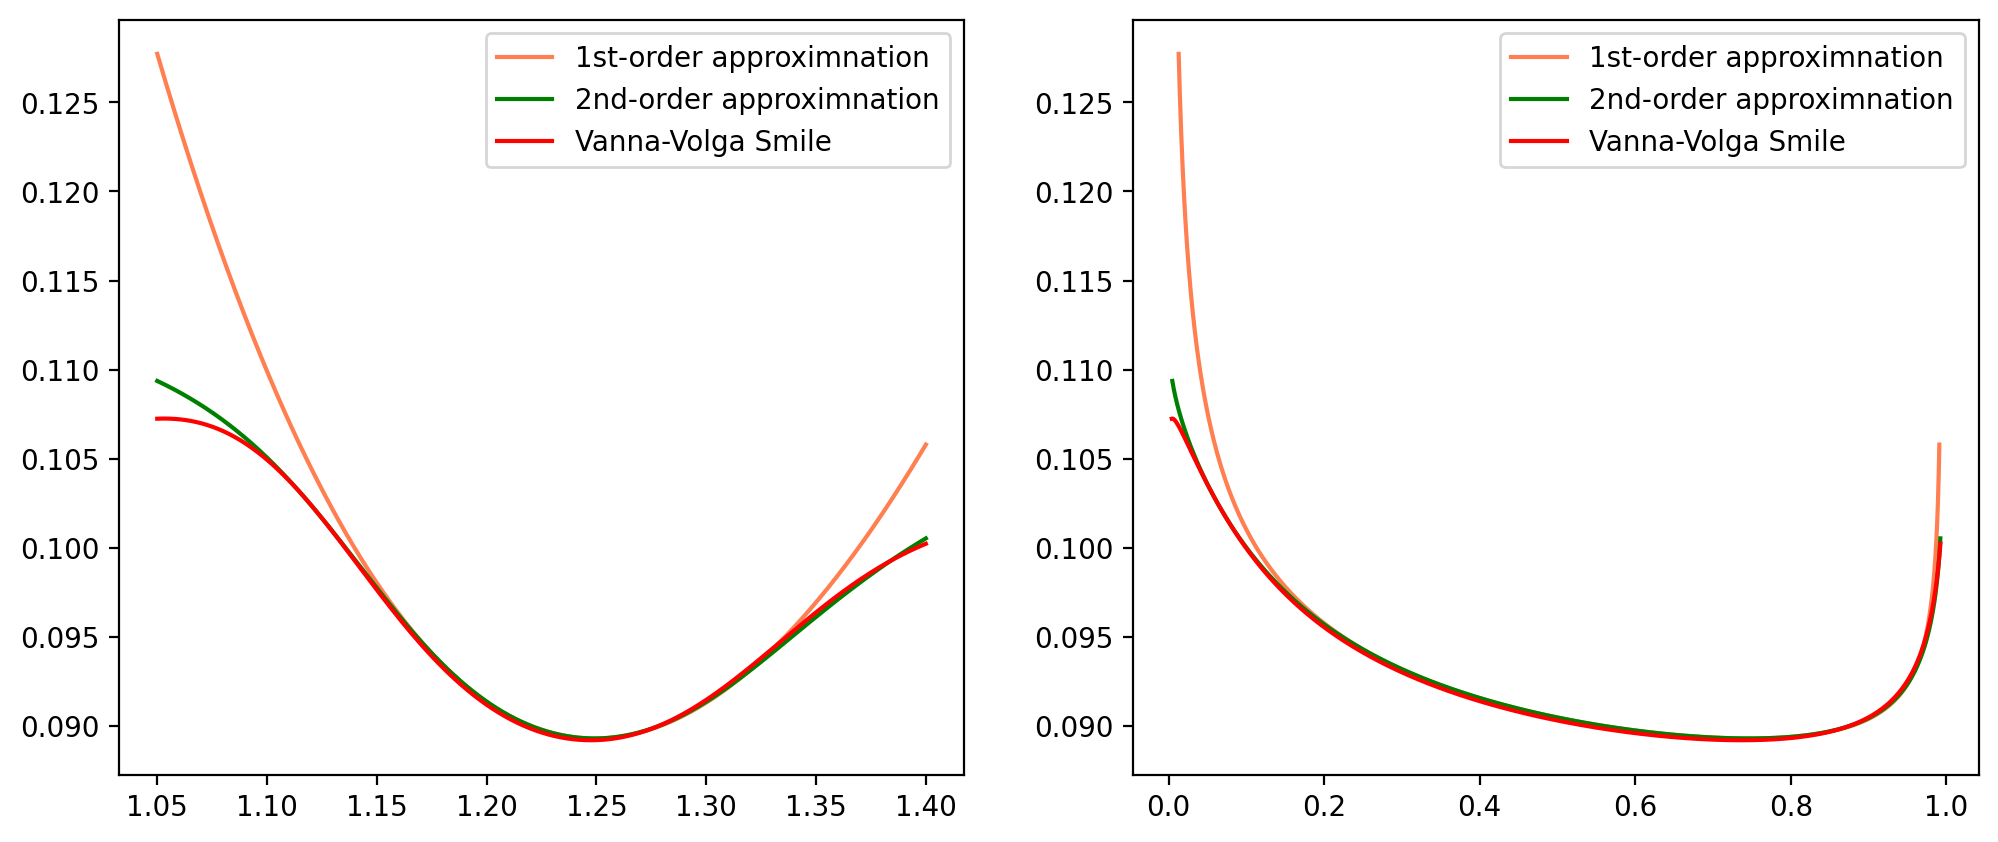

In [457]:
### market data
spot = 1.205
time_to_expiry = 94/365
vol_atm = 9.05/100
rr = -0.5/100
vwb = 0.13/100
domestic_discount_factor = 0.990275201
foreign_discount_factor = 0.994585501
###  
vol_25p = vol_atm + vwb - 0.5*rr
vol_25c = vol_atm + vwb + 0.5*rr
strike_25p = get_strike_from_delta(omega = -1,
                                   spot = spot,
                                   volatility = vol_25p, 
                                   time_to_expiry = time_to_expiry, 
                                   domestic_discount_factor = domestic_discount_factor, 
                                   foreign_discount_factor = foreign_discount_factor,
                                   delta = 0.25, 
                                   premium_included = False)

strike_25c = get_strike_from_delta(omega = 1,
                                   spot = spot,
                                   volatility = vol_25c, 
                                   time_to_expiry = time_to_expiry, 
                                   domestic_discount_factor = domestic_discount_factor, 
                                   foreign_discount_factor = foreign_discount_factor,
                                   delta = 0.25, 
                                   premium_included = False)

strike_atm = get_strike_from_delta(omega = -1,
                                   spot = spot,
                                   volatility = vol_atm, 
                                   time_to_expiry = time_to_expiry, 
                                   domestic_discount_factor = domestic_discount_factor, 
                                   foreign_discount_factor = foreign_discount_factor,
                                   delta = 0.5, 
                                   premium_included = False)
input_strikes = [strike_25p, strike_atm, strike_25c]
input_vols = [vol_25p, vol_atm, vol_25c]





### Compute the implied volatilities
K = np.linspace(1.05, 1.40, 1000)
first_order_iv = get_implied_vol_approximation(strike  = K, 
                                              input_strikes = input_strikes, 
                                              input_vols = input_vols,
                                              spot = spot,
                                              time_to_expiry = time_to_expiry,
                                              domestic_discount_factor = domestic_discount_factor,
                                              foreign_discount_factor = foreign_discount_factor,
                                              method = "1st-order") 
second_order_iv = get_implied_vol_approximation(strike  = K, 
                                              input_strikes = input_strikes, 
                                              input_vols = input_vols,
                                              spot = spot,
                                              time_to_expiry = time_to_expiry,
                                              domestic_discount_factor = domestic_discount_factor,
                                              foreign_discount_factor = foreign_discount_factor,
                                              method = "2nd-order") 

vv_price = []
vv_smile = []
bs_price = []
for k in K:
    vv_price.append(get_vv_price(omega = -1,
                             spot = spot, 
                             time_to_expiry = time_to_expiry,
                             input_strikes = input_strikes, 
                             input_vols = input_vols,
                             strike = k,
                             domestic_discount_factor = domestic_discount_factor,
                             foreign_discount_factor = foreign_discount_factor,
                             method = "simplified"))
    vv_smile.append(get_implied_vol_from_option_price(omega = -1, 
                                                  option_price = vv_price[-1], 
                                                  spot = spot, 
                                                  strike = k,
                                                  time_to_expiry = time_to_expiry, 
                                                  domestic_discount_factor = domestic_discount_factor, 
                                                  foreign_discount_factor = foreign_discount_factor))


    
### Compute the volatilities in terms of Delta
delta_1 = []
delta_2 = []
delta_3 = []
for count, k in enumerate(K):
    delta_1.append(abs(get_delta(omega = -1, 
                                spot = spot, 
                                volatility = first_order_iv[count],
                                time_to_expiry = time_to_expiry, 
                                strike = k,
                                domestic_discount_factor = domestic_discount_factor, 
                                foreign_discount_factor = foreign_discount_factor,
                                delta_type = "st")))
    delta_2.append(abs(get_delta(omega = -1, 
                                spot = spot, 
                                volatility = second_order_iv[count],
                                time_to_expiry = time_to_expiry, 
                                strike = k,
                                domestic_discount_factor = domestic_discount_factor, 
                                foreign_discount_factor = foreign_discount_factor,
                                delta_type = "st")))
    delta_3.append(abs(get_delta(omega = -1, 
                                spot = spot, 
                                volatility = vv_smile[count],
                                time_to_expiry = time_to_expiry, 
                                strike = k,
                                domestic_discount_factor = domestic_discount_factor, 
                                foreign_discount_factor = foreign_discount_factor,
                                delta_type = "st")))
    
### Display on plots
fig, ax = plt.subplots(1, 2, figsize = (12,5), dpi = 200)
ax[0].plot(K, first_order_iv, label = "1st-order approximnation", color = "coral")
ax[0].plot(K, second_order_iv, label = "2nd-order approximnation", color = "green")
ax[0].plot(K, vv_smile, label = "Vanna-Volga Smile", color = "red")
ax[0].legend()

ax[1].plot(delta_1, first_order_iv, label = "1st-order approximnation", color = "coral")
ax[1].plot(delta_2, second_order_iv, label = "2nd-order approximnation", color = "green")
ax[1].plot(delta_3, vv_smile, label = "Vanna-Volga Smile", color = "red")
ax[1].legend()



## Features of the Vanna-Volga Approach

### Hedging error for longer expiries
In this section we gauge the hedging error that springs from carrying out the strategy for an arbitrary expiry, assuming a continuous rebalancing. The total hedging error at maturity $T$ is given by:
\begin{align}
\varepsilon_{T} = \sum^3_{i =1} \int^T_0 e^{\int^T_t r^d_s ds}dx_i (t;K) [C^{\text{MKT}}_i (t + dt) - C^{\text{BS}}_i (t + dt)]
\label{eq:vv_hedging_error}
\end{align}
Equation \ref{eq:vv_hedging_error} provides a useful insight into the accuracy of the replication strategy in a stochastic volatility world: the greater the difference between the market price and the flat-smile price of the three basic options, the higher the total hedging error $\varepsilon_T$. The total hedging error is the sum of the differences in prices not taken into account by the flat-smile hypothesis times the variations in their quantities in the portfolio. 
The differences in prices are only relevant when rebalancing happens, so we can reasonably believe that the error is not large and that it will larger for far OTM strikes (since more rebalancing is likely to happen). 

### Implied Risk-neutral density
The knowledge of option prices for every possible strike identifies a unique risk-neutral density that is consistent with the prices. By the result Breeden and Litzenberger, the risk-neutral density $p_T$ of the asset $S_T$ can be obtained by differentiating twice the option price in \ref{eq:vv_price}:
\begin{align}
\begin{split}
p_T(K) =& \frac{1}{P^d(0,T)} \frac{\partial^2 C}{\partial K^2}(K) \\
=& \frac{1}{P^d(0,T)} \frac{\partial^2 C^{\text{BS}}}{\partial K^2}(K) \\
&+ \frac{1}{P^d(0,T)} \sum_{i \in \{1,3\}} \frac{\partial^2 x_i}{\partial K^2}(K) [C^{\text{MKT}}(K_i) - C^{\text{BS}}(K_i)]
\end{split}
\end{align}
And the second order differentiate of the weights are:
\begin{align*}
\frac{\partial^2 x_1}{\partial K^2} (K) =& \frac{\mathcal{V}(K)}{K^2\sigma^2 T \mathcal{V}(K_1) \ln \frac{K_2}{K_1} \ln \frac{K_3}{K_1}} \\
&\bigg[\big(d_1(K)^2 - \sigma \sqrt{T} d_1(K) - 1 \big) \ln \frac{K_2}{K} \ln \frac{K_3}{K} \\
& -2 \sigma \sqrt{T} d_1(K) \ln \frac{K_2 K_3}{K^2} + \sigma^2 T \big(\ln \frac{K_2 K_3}{K^2} + 2 \big)\bigg]\\
\frac{\partial^2 x_3}{\partial K^2} (K) =& \frac{\mathcal{V}(K)}{K^2\sigma^2 T \mathcal{V}(K_3) \ln \frac{K_3}{K_1} \ln \frac{K_3}{K_2}} \\
&\bigg[\big(d_1(K)^2 - \sigma \sqrt{T} d_1(K) - 1 \big) \ln \frac{K_2}{K} \ln \frac{K_1}{K} \\
& -2 \sigma \sqrt{T} d_1(K) \ln \frac{K_1 K_2}{K^2} + \sigma^2 T \big(\ln \frac{K_1 K_2}{K^2} + 2 \big)\bigg]\\
\end{align*}

## Smile Interpolation among Expiries: Implied volatility term structure
<!-- For the FX options market, a form of the Heston-type model for instanteneous variance of the underlying asset has been proposed to fit the term structure of ATM volatilities.
\begin{align}
\zeta^2(t) &= \sigma^2_\infty + (\zeta^2_0 - \sigma^2_\infty)e^{-\kappa t}
\label{eq:term_structure_simple_func}
\end{align}
The instanteneous variance $\zeta^2(t)$ evovles toward a long-term average level $\sigma^2_\infty$ by a mean-reversion speed $\kappa$, starting from an initial level $\zeta_0$. To retrieve the implied volatility for a given expiry $T$, one has to integrate \ref{eq:term_structure_simple_func}, divide the result by the time to expiry $T$ and take the square root:
\begin{align}
\sigma(T) &= \sqrt{\frac{\int^T_0 \zeta^2(t)dt}{T}} = \sqrt{\sigma^2_\infty + (\zeta^2_0 - \sigma^2_\infty) \frac{1 - e^{\kappa T}}{\kappa T}}
\label{eq:iv_term_structure}
\end{align}
Usually the fit to the market data is not completely satisfactory, and one must resort to some time dependency of the parameters. -->

The volatility interpolation between two given expiries needs to be implemented correctly by taking into account the daily variations and weighting the days with sensible factors. We stress that the interpolation of the term structure refers *only to the ATM volatility* and thus concerns only the level of the surface. Our problem is to devise a method to interpolate consistently between two contiguous dates. We call such method the **Total Variance Interpolation Method**.

We know the squared implied volatility for expiry $T$ is given by
\begin{align*}
\sigma^2(T) &= \frac{1}{T} \int^T_0 \zeta^2(t)dt = V(T)
\end{align*}
The volatility between two dates $T_i \leq T \leq T_{i+1}$ can be obtained by linearly interpolating the mean variance between $T_i$ and $T_{i+1}$ values. We get
\begin{align*}
\int^T_0 \zeta^2(t)dt &= \frac{V(T_{i+1}) - V(T_i}{T_{i+1} - T_i}(T - T_i) + V(T_i) \\
&= \frac{T_{i+1}\sigma^2(T_{i+1}) - T_i \sigma^2(T_i)}{T_{i+1} - T_i}(T - T_i) + T_i \sigma^2(T_i) \\
&= \frac{T- T_i}{T_{i+1} - T_i} T_{i+1} \sigma^2(T_{i+1}) + \frac{T_{i+1} - T}{T_{i+1} - T_i} T_i \sigma^2(T_i)
\end{align*}
and hence
\begin{align}
\sigma(T) = \sqrt{\frac{T- T_i}{T_{i+1} - T_i} \frac{T_{i+1}}{T} \sigma^2(T_{i+1}) + \frac{T_{i+1} - T}{T_{i+1} - T_i} \frac{T_i}{T} \sigma^2(T_i)}
\label{eq:term_structure_interpolation}
\end{align}

The next step is to take the weighting of the days entering the interpolation into account, since holidays and other events may affect the daily volatility heavily. The steps are as follows:
1. Calculate the number of days $N_1$ occuring between $T_i$ and T and the number of days $N_2$ occurring between $T_i$ and $T_{i+1}$.
1. Associate each day with a proper weight $w_i$:
    - $w_i = 1$ for a normal business day
    - $w_i < 1$ for holidays in the underlying markets (e.g., in the FX market, it can be set equal to 0.5 if the day is a holiday in one of the two countries involved or it can be set at 0 for weekends).
    - $w_i > 1$ for days when special events are expected (e.g., key economics figures are released).
1. Set 
\begin{align*}
\tau_1 = \frac{\sum^{N_1}_{i=1}w_i}{N_y}, ~\tau_2 = \frac{\sum^{N_2}_{i=1}w_i}{N_y}
\end{align*}
where $N_y$ is the total number of days in the year ($N_y = 365$ or $366$)
1. Replace $T- T_i$ with $\tau_1$ and $T_{i+1} - T_i$ with $\tau_2$ in the interpolation formula \ref{eq:term_structure_interpolation}:
\begin{align}
\sigma(T) = \sqrt{\frac{\tau_1}{\tau_2} \frac{T_{i+1}}{T} \sigma^2(T_{i+1}) + \frac{\tau_2 -\tau_1}{\tau_2} \frac{T_i}{T}\sigma^2(T_i)}
\end{align}

This interpolation method is used only for the ATM volatilities. If the implied volatility of an OTM option has to be recovered, then one can first interpolate the ATM volatility, then use a simple linear interpolation for the risk reversal and butterfly and finally use the method explained previously to generate volatility smile curve. 

The rationale behind this is the higher-order moments (skewness and kurtosis) are more stable and smoothly changing between expiries, whereas the daily volatility (i.e. the second moement of the price returns' distribution) can be affected by the related market activity. 

This justifies the weighted interpolation for the ATM volatility, which impacts the level of the volaitlity surface and hence the second moment of the price returns' distribution, and also justifies the linear interpolation for the risk reversal and the butterfly which measure the slope and convexity of the volatility surface and hence the skewness and kurtosis of the returns' distribution.


## Admissible Volatility Surfaces
Every volatility surface must satisfy some (necessary and sufficient) conditions in order to rule out any arbitrage opportunities exploited by means of static positions set up at time $t$. 


1. Call/put spread: call options struck at a given level must be worth more than an otherwise identical call struck at a higher price; Similarly, a put option must be worth more than an otherwise identical put struck at a lower price.
\begin{align}
\frac{\partial Bl(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, \omega)}{\partial K} |_{\omega = 1} &\leq 0 \\
\frac{\partial Bl(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, \omega)}{\partial K} |_{\omega = -1} &\geq 0 \\
\end{align}

1. The volatility smile curve must be a convex function at a given maturity:
\begin{align}
\frac{\partial^2 Bl(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, \omega)}{\partial K^2}  &> 0  
\end{align}

1. The slope with respect to the time to maturity of the surface must be positive. It should not be possible to buy an option and sell an otherwise identical option with a shorter time to maturity without paying a premium:
\begin{align}
\frac{\partial Bl(S_t, t, T, K, P^d(t,T), P^f(t,T), \sigma, \omega)}{\partial T} &> 0  
\label{eq:admissible_vol_surface_condition_three}
\end{align}
In general, the Theta of an option is usually a positive function of the time to maturity. However, sometimes for deep ITM options, where there is a huge difference between domestic and foreign interest rates, the Theta could be negatively related to the time to maturity. To avoid this, one can check the admissibility of the volatility surface with OTM options, for which condition \ref{eq:admissible_vol_surface_condition_three} is always a bounding constraint.

## Taking the Market Butterfly into Account
So far we have not considered market inconsistency that can be safely disregarded in many situations (such as configurations of prices), but that can have a deep impact on the volatility surface building.

Given the quotations of $\sigma_{\text{ATM}}$, 25D RR and VWB, it is straightforward to get the volatilities for the 25D strikes:
\begin{align*}
\sigma_{\text{25P}}(t, T) &= \sigma_{\text{ATM}}(t,T) + \text{vwb}(t,T;25) - 0.5\text{rr}(t,T;25)  \\ 
\sigma_{\text{25C}}(t, T) &= \sigma_{\text{ATM}}(t,T) + \text{vwb}(t,T;25) + 0.5\text{rr}(t,T;25)  \\ 
\end{align*}

From these volatilities, we can calculate the strikes corresponding to the 25D and ATM levels. However, it should now be stressed that this **is not fully consistent** with the market standard conventions for trading the VWB.
\begin{align}
K_{25P} &= F(t,T)e^{\sigma_{\text{25P}} \sqrt{T-t} \Phi^{-1}(0.25/P^f(t,T)) + 0.5 \sigma^2_{\text{25P}}(T-t)} \\
K_{25C} &= F(t,T)e^{-\sigma_{\text{25C}} \sqrt{T-t} \Phi^{-1}(0.25/P^f(t,T)) + 0.5 \sigma^2_{\text{25C}}(T-t)} 
\end{align}
These two formulae are used when an RR is traded. If the market convention for the pair is to pay the premium as $\%$ of the base currency, then we must use the numerical procedure described before.

The market standard convention for trading the VWB, the two 25D wing strikes are calculated by defining a single volatility (disregarding the RR price):
\begin{align}
\sigma_{\text{VWB}} &= \sigma_{\text{ATM}}(t,T) + \text{vwb}(t,T;25) 
\end{align}
and so the two strikes corresponding to the 25D wings are calculated as, 
\begin{align}
\overline{K}_{25P} &= F(t,T)e^{\sigma_{\text{25P}} \sqrt{T-t} \Phi^{-1}(0.25/P^f(t,T)) + 0.5 \sigma^2_{\text{25P}}(T-t)} \\
\overline{K}_{25C} &= F(t,T)e^{-\sigma_{\text{25C}} \sqrt{T-t} \Phi^{-1}(0.25/P^f(t,T)) + 0.5 \sigma^2_{\text{25C}}(T-t)} 
\end{align}


To sum up, if we use a smile function built with the market prices plainly as they deal (without considering actual market conventions for the VWB), and we make prices by means of it, we can be arbitraged. In Example 4.9.1., if we consider a RR trade, the total cost of the wings (sum of 25D call & put) will be **2.61**. If we consider the conventions for VWB, the cost of the two wings will be **2.63**. If we are asked for the price of the two options separately, we will use the exact implied volatilities provided by the smile function and the total cost will be **2.44**. Hence, there exists an arbitrage opportunity. We have to find a way to rule this out,  making the entire smile arbitrage-free, albeit in line with the prices of the RR and the VWB.

We want to build a volatility surface taking into account all the market conventions. In practice we want that the two 25D options priced according to the volatility surface we employ have the same value as calculated according to the one-volatility standard (the ATM STDL). Thus we have two requirements:

1. The VWB price:
\begin{align}
C(\overline{K}_{\text{25C}}, \sigma(\overline{K}_\text{25C})) + P(\overline{K}_{\text{25P}}, \sigma(\overline{K}_\text{25P})) &= C(\overline{K}_{\text{25C}}, \sigma_{\text{VWB}})) + P(\overline{K}_{\text{25P}}, \sigma_{\text{VWB}}))
\label{eq:smile_constraint_1}
\end{align}
The LHS of the equation is the sum of two options struck 25D strikes valued with the implied volatility retrieved from the smile function. The RHS is the sum of the prices of the same options valued with the same volatility $\sigma_{\text{VWB}}$.

1. The price of an RR must match that dealing in the market: $rr = \sigma(K_c) - \sigma(K_p)$

To recapitulate, given the market prices $\sigma_{\text{ATM}}$, $rr$ and $\text{vwb}$, we have to determine an equivalent 25D $\text{vwb}_e$ price so that the smile we build matches all the requirements above. The solution to this is found numerically by the following procedure:
1. For a given expiry, calculate the conventional volatility for the 25D VWB: $\sigma_{\text{VWB}} = \sigma_{\text{ATM}} + \text{vwb}$ and the ATM strike:
\begin{align*}
K_{\text{ATM}} &= \begin{cases}
    F(t,T)e^{0.5 \sigma^2_{\text{ATM}} (T-t)} & \text{Standard Delta} \\
    F(t,T)e^{-0.5 \sigma^2_{\text{ATM}} (T-t)} & \text{Premium-included Delta} 
    \end{cases}
\end{align*}
1. Set $i = 0$ and $\text{vwb}^i_e = \text{vwb}$ when $i = 0$. Calculate the two 25D volatilities in a "consistent" way: 
\begin{align*}
\sigma_{25P} &= \sigma_{\text{ATM}} + \text{vwb}^i_e - 0.5rr \\
\sigma_{25C} &= \sigma_{\text{ATM}} + \text{vwb}^i_e + 0.5rr \\
\end{align*}
1. Calculate the 25D strikes for the "consistent" volatilities, $\sigma_{25P}$,  $\sigma_{25C}$.
1. Calculate the 25D strikes for the market VWB volatility, $\sigma_{\text{VWB}}$.
1. Calculate the difference between the STGL struck at market VWB levels and the STGL valued with the conventional volatility $\sigma_{VWB}$:
\begin{align*}
\mathcal{S}^i =& C(\overline{K}^i_{25C}, \sigma(\overline(K)^i_{25C})) + P(\overline{K}^i_{25P}, \sigma(\overline(K)^i_{25P})) \\
&- [C(\overline{K}^i_{25C}, \sigma_{\text{VWB}}) + P(\overline{K}^i_{25P}, \sigma_{\text{VWB}})]
\end{align*}
1. Shift the equivalent VWB price by one basis point (0.0001) only for the first iteration $i= 0$ (for precision's sake). Increase $i$ by 1, perform the same calculations with the new $\text{vwb}^{i+1}_e$ to calculate the new 25D volatilities and strikes, and the new difference $\mathcal{S}^i$. 
1. Calculate the numerical derivatives of the quantity \mathcal{S} with respect to the $\text{vwb}_e$:
\begin{align*}
\frac{d \mathcal{S}^i}{d \text{vwb}^{i}_e} &= \frac{\mathcal{S}^i - \mathcal{S}^{i-1}}{\text{vwb}^{i}_e - \text{vwb}^{i-1}_e}
\end{align*}
1. Calculate the new $\text{vwb}^{i+1}_e = \text{vwb}^{i}_e - \frac{\mathcal{S}^i}{\frac{d \mathcal{S}^i}{d \text{vwb}^{i}_e}}$
1. Iterate until $|\mathcal{S}^i - \mathcal{S}^{i-1}| < \varepsilon$. 

In [439]:
spot = 102.65
domestic_discount_factor = 0.9949767
foreign_discount_factor = 0.98356851
vol_atm = 11.95/100
rr = -4.7/100
vwb = 0.12/100
time_to_expiry = 183/365

print("-------------------")
print("|  RR convention  |")
print("-------------------")

# Calculate using the usual relationships linking the three prices
vol_25p = vol_atm + vwb - 0.5*rr
print(f"Vol 25D Put = {vol_25p:.4f}")
vol_25c = vol_atm + vwb + 0.5*rr
print(f"Vol 25D Call = {vol_25c:.4f}")
# Calculate the corresponding strikes using get_strike_from_delta
strike_25p = get_strike_from_delta(omega = -1,
                                   spot = spot,
                                   volatility = vol_25p, 
                                   time_to_expiry = time_to_expiry, 
                                   domestic_discount_factor = domestic_discount_factor, 
                                   foreign_discount_factor = foreign_discount_factor,
                                   delta = 0.25, 
                                   premium_included = True)
print(f"25D Put strike = {strike_25p:.2f}")
strike_25c = get_strike_from_delta(omega = 1,
                                   spot = spot,
                                   volatility = vol_25c, 
                                   time_to_expiry = time_to_expiry, 
                                   domestic_discount_factor = domestic_discount_factor, 
                                   foreign_discount_factor = foreign_discount_factor,
                                   delta = 0.25, 
                                   premium_included = True)
print(f"25D Call strike = {strike_25c:.2f}")
# Calculate the call and put options price at 25D in USD %
call_25d = get_bs_price(omega = 1,
                     spot = spot, 
                     volatility = vol_25c, 
                     time_to_expiry = time_to_expiry,
                     strike = strike_25c,
                     domestic_discount_factor = domestic_discount_factor, 
                     foreign_discount_factor = foreign_discount_factor)
print(f"25D Call price = {call_25d:.4f}")
put_25d = get_bs_price(omega = -1,
                     spot = spot, 
                     volatility = vol_25p, 
                     time_to_expiry = time_to_expiry,
                     strike = strike_25p,
                     domestic_discount_factor = domestic_discount_factor, 
                     foreign_discount_factor = foreign_discount_factor)
print(f"25D Put price = {put_25d:.4f}")
# Calculate 25D strangle price
stgl_25d = call_25d + put_25d
print(f"25D STGL price = {stgl_25d:.4f}")



### If the VWB is traded
print("-------------------")
print("|  VWB convention |")
print("-------------------")
vol_vwb = vol_atm + vwb
print(f"Vol vwb = {vol_vwb}")
vwb_strike_25p = get_strike_from_delta(omega = -1,
                                       spot = spot,
                                       volatility = vol_vwb, 
                                       time_to_expiry = time_to_expiry, 
                                       domestic_discount_factor = domestic_discount_factor, 
                                       foreign_discount_factor = foreign_discount_factor,
                                       delta = 0.25, 
                                       premium_included = True)
print(f"25D Put strike = {vwb_strike_25p:.2f}")
vwb_strike_25c = get_strike_from_delta(omega = 1,
                                       spot = spot,
                                       volatility = vol_vwb, 
                                       time_to_expiry = time_to_expiry, 
                                       domestic_discount_factor = domestic_discount_factor, 
                                       foreign_discount_factor = foreign_discount_factor,
                                       delta = 0.25, 
                                       premium_included = True)
print(f"25D Call strike = {vwb_strike_25c:.2f}")

# The corresponding option premium in USD % 
call_25_vwb = get_bs_price(omega = 1,
                         spot = spot, 
                         volatility = vol_vwb, 
                         time_to_expiry = time_to_expiry,
                         strike = vwb_strike_25c,
                         domestic_discount_factor = domestic_discount_factor, 
                         foreign_discount_factor = foreign_discount_factor)
print(f"25D Call price (vol vwb) = {call_25_vwb:.4f}")

put_25_vwb = get_bs_price(omega = -1,
                         spot = spot, 
                         volatility = vol_vwb, 
                         time_to_expiry = time_to_expiry,
                         strike = vwb_strike_25p,
                         domestic_discount_factor = domestic_discount_factor, 
                         foreign_discount_factor = foreign_discount_factor)
print(f"25D Put price (vol vwb) = {put_25_vwb:.4f}")
# The price of 25D stgl (vol_vwb as vol input)
print(f"25D STGL price (vol vwb)= {call_25_vwb + put_25_vwb:.4f}")


### Use iv approximation from volatility surface to calculate call/put prices and 25D strangle
print("-----------------------")
print("|  Volatility Surface |")
print("-----------------------")
strike_25p = strike_25p
strike_atm = get_strike_from_delta(omega = -1,
                                      spot = spot,
                                      volatility = vol_atm, 
                                      time_to_expiry = time_to_expiry, 
                                      domestic_discount_factor = domestic_discount_factor, 
                                      foreign_discount_factor = foreign_discount_factor, 
                                      delta = 0.5, premium_included = True)
strike_25c = strike_25c
input_strikes = [strike_25p, strike_atm, strike_25c]

vol_25p = vol_25p
vol_atm = vol_atm
vol_25c = vol_25c
input_vols = [vol_25p, vol_atm, vol_25c]

vol_25p_from_vol_surface = get_implied_vol_approximation(
    strike = vwb_strike_25p, 
    input_strikes = input_strikes, 
    input_vols = input_vols, 
    spot = spot,
    time_to_expiry = time_to_expiry,
    domestic_discount_factor = domestic_discount_factor,
    foreign_discount_factor = foreign_discount_factor, 
    method = "2nd-order") 
print(f"Vol 25D Put (vol Surface) = {vol_25p_from_vol_surface:.4f}")

vol_25c_from_vol_surface = get_implied_vol_approximation(
    strike = vwb_strike_25c, 
    input_strikes = input_strikes, 
    input_vols = input_vols, 
    spot = spot,
    time_to_expiry = time_to_expiry,
    domestic_discount_factor = domestic_discount_factor,
    foreign_discount_factor = foreign_discount_factor, 
    method = "2nd-order") 
print(f"Vol 25D Call (vol Surface) = {vol_25c_from_vol_surface:.4f}")

# BS prices
call_25_iv = get_bs_price(omega = 1,
                         spot = spot, 
                         volatility = vol_25c_from_vol_surface,
#                           volatility = 9.12/100,
                         time_to_expiry = time_to_expiry,
                         strike = vwb_strike_25c,
#                          strike = 107.3774,
                         domestic_discount_factor = domestic_discount_factor, 
                         foreign_discount_factor = foreign_discount_factor)
print(f"25D Call price (vol surface) = {call_25_iv:.2f}")

put_25_iv = get_bs_price(omega = -1,
                         spot = spot, 
                         volatility = vol_25p_from_vol_surface, 
#                          volatility = 14.06/100, 
                         time_to_expiry = time_to_expiry,
                         strike = vwb_strike_25p,
#                          strike = 95.9080,
                         domestic_discount_factor = domestic_discount_factor, 
                         foreign_discount_factor = foreign_discount_factor)
print(f"25D Put price (vol surface) = {put_25_iv:.2f}")

### The price of 25D stgl (vol_vwb as vol input)
print(f"25D STGL price (vol surface)= {call_25_iv + put_25_iv:.2f}")

-------------------
|  RR convention  |
-------------------
Vol 25D Put = 0.1442
Vol 25D Call = 0.0972
25D Put strike = 94.88
25D Call strike = 106.21
25D Call price = 1.0810
25D Put price = 1.5265
25D STGL price = 2.6074
-------------------
|  VWB convention |
-------------------
Vol vwb = 0.1207
25D Put strike = 95.92
25D Call strike = 107.39
25D Call price (vol vwb) = 1.3490
25D Put price (vol vwb) = 1.2837
25D STGL price (vol vwb)= 2.6327
-----------------------
|  Volatility Surface |
-----------------------
Vol 25D Put (vol Surface) = 0.1402
Vol 25D Call (vol Surface) = 0.0917
25D Call price (vol surface) = 0.71
25D Put price (vol surface) = 1.73
25D STGL price (vol surface)= 2.44


In [433]:
get_equiv_vwb_from_market_vwb(spot = 102.65,
                            domestic_discount_factor = 0.9949767,
                            foreign_discount_factor = 0.98356851,
                            vol_atm = 11.95/100,
                            rr = -4.7/100,
                            market_vwb = 0.12/100,
                            time_to_expiry = 183/365)    

0.005326383530837641


## Building the Volatility Matrix in Practice
In this section we examine a real market situaion so as to show how to employ these tools in practice. The market prices for the ATM STDL, the 25D RR and the 25D VWB will be available. In the following example, EURUSD is used. Its market conventions are for the option's premium to be paid in numeraire currency pips. 

The steps to build a volaitlity matrix (surface) from the market quotes - the ATM STDL, the 25D RR and the 25D VWB are:
1. Calculate the equivalent 25D VWB prices originated from the real market prices. 
1. Calculate the volatilities for the ATM ($\sigma_{\text{ATM}}$) and 25D call ($\sigma_{\text{25C}}$) and put ($\sigma_{\text{25P}}$) strikes.
1. Then, calculate the strikes referring to the basic structures - $K_{\text{ATM}}$, $K_P$ and $K_C$. It is worth stressing that the ATM strike level for expiries longer than **two years** is simply the forward price.
1. Use the VV implied volatility approximation to calculate volatilities for 10%, 15%, 20%, 25% and 35% call / put delta.
1. Apply a weighted interpolation to the term structure.

In [231]:
# Parameters
spot = 1.5184

### Generate tenor dates for EURUSD
eurusd_tenor = TenorDates(ccy = "EURUSD")
date = datetime.strptime("29-02-2008", "%d-%m-%Y")
df_tenor = eurusd_tenor.populate_expiry_dates(horizon_date = date, return_df = True)

### ATM STDL, 25D RR & 25D Fly quotes
atm_quote = [7.50, 11.00,10.40,9.70,9.65, 9.53, 9.33, 9.25, 9.18, 8.95, 8.90, 8.90] 
rr_quote = [0.50, 0.29, 0.21, -0.05, -0.20, -0.30, -0.40, -0.45, -0.48, -0.48, -0.48, -0.48]
fly_quote = [0.20, 0.20, 0.20, 0.20, 0.22, 0.25, 0.33, 0.36, 0.38, 0.31, 0.31, 0.28]
df_quotes = pd.DataFrame({"ATM (%)": atm_quote, "25D RR (%)": rr_quote, "25D Fly (%)": fly_quote})
df_quotes = pd.concat([df_tenor, df_quotes], axis = 1)
# display(df_quotes)

### Calculate the implied volatilities for the ATM, 25D call and put strikes, and prices of domestic (USD) and foreign (EUR) zero-coupon bonds
domestic_discount_factor = [0.999737, 0.999387, 0.998779, 0.997132, 0.994686, 0.992006, 0.985281, 0.975910, 0.970856, 0.949348, 0.840130, 0.643859]
foreign_discount_factor = [0.999666, 0.999218, 0.998429, 0.996257, 0.992191, 0.988242, 0.977018, 0.966284, 0.956071, 0.927723, 0.824089, 0.649933]
df_iv = df_quotes.copy()
df_iv["25D Put (%)"] = df_iv["ATM (%)"] + df_iv["25D Fly (%)"] - 0.5*df_iv["25D RR (%)"]
df_iv["25D Call (%)"] = df_iv["ATM (%)"] + df_iv["25D Fly (%)"] + 0.5*df_iv["25D RR (%)"]
df_iv = df_iv.drop(["25D Fly (%)", "25D RR (%)"], axis = 1).round(2)
df_iv["Pd"] = domestic_discount_factor
df_iv["Pf"] = foreign_discount_factor
df_iv = df_iv[["Horizon", "Tenor", "Expiry Date", "25D Put (%)", "ATM (%)", "25D Call (%)", "Pd", "Pf"]]
# display(df_iv)

### Calculate the strikes (EURUSD option premium in numeraire ccy pips)
df_strikes = df_iv.copy()
df_strikes["K_25p"] = df_strikes.apply(lambda x: get_strike_from_delta(omega = -1, 
                                                                       spot = spot, 
                                                                       volatility = x["25D Put (%)"]/100, 
                                                                       time_to_expiry = (datetime.strptime(x["Expiry Date"], "%a %d-%b-%Y") - date).days/365, 
                                                                       domestic_discount_factor = x["Pd"], 
                                                                       foreign_discount_factor = x["Pf"],
                                                                       delta = 0.25, 
                                                                       premium_included = False), axis = 1)
df_strikes["K_atm"] = df_strikes.apply(lambda x: get_strike_from_delta(omega = 1, 
                                                                       spot = spot, 
                                                                       volatility = x["ATM (%)"]/100, 
                                                                       time_to_expiry = (datetime.strptime(x["Expiry Date"], "%a %d-%b-%Y") - date).days/365, 
                                                                       domestic_discount_factor = x["Pd"], 
                                                                       foreign_discount_factor = x["Pf"],
                                                                       delta = 0.50, 
                                                                       premium_included = False), axis = 1)

df_strikes["K_25c"] = df_strikes.apply(lambda x: get_strike_from_delta(omega = 1, 
                                                                       spot = spot, 
                                                                       volatility = x["25D Call (%)"]/100, 
                                                                       time_to_expiry = (datetime.strptime(x["Expiry Date"], "%a %d-%b-%Y") - date).days/365, 
                                                                       domestic_discount_factor = x["Pd"], 
                                                                       foreign_discount_factor = x["Pf"],
                                                                       delta = 0.25, 
                                                                       premium_included = False), axis = 1)
display(df_strikes)

### Compute the VV implied volatility approximation
# Call
df_call_iv = df_strikes.copy()
strike_range = np.linspace(1.05, 1.95, 10000)
vol_at_target_strike = pd.DataFrame(columns = ["Delta 35% (%)", "Delta 25% (%)", "Delta 20% (%)", "Delta 15% (%)", "Delta 10% (%)"])

for i in range(len(df_call_iv)):
    time_to_expiry = (datetime.strptime(df_call_iv["Expiry Date"].iloc[i], "%a %d-%b-%Y") - date).days/365                                                    
    vol_across_strike = get_implied_vol_approximation(strike = strike_range, 
                                                      input_strikes =  list(df_call_iv[["K_25p", "K_atm", "K_25c"]].iloc[i]),
                                                      input_vols = list(df_call_iv[["25D Put (%)", "ATM (%)", "25D Call (%)"]].iloc[i]/100), 
                                                      spot = spot,
                                                      time_to_expiry = time_to_expiry,
                                                      domestic_discount_factor = df_call_iv["Pd"].iloc[i],
                                                      foreign_discount_factor = df_call_iv["Pf"].iloc[i], 
                                                      method = "2nd-order") 
    # calculate the corresponding delta_range
    delta_range = []
    for count, strike in enumerate(strike_range):
        # EURUSD Delta's convention is in numeraire ccy pips, hence 
        delta_range.append(abs(get_delta(omega = 1, 
                                        spot = spot, 
                                        volatility = vol_across_strike[count],
                                        time_to_expiry = time_to_expiry, 
                                        strike = strike,
                                        domestic_discount_factor = df_call_iv["Pd"].iloc[i],
                                        foreign_discount_factor = df_call_iv["Pf"].iloc[i], 
                                        delta_type = "st")))
    delta_range = np.array(delta_range)
    # Find the idx where delta values are closest to that of our interest, this will the idx for strike_range
    target_delta_values = [0.35, 0.25, 0.20, 0.15, 0.10]
    idx = []
    for delta in target_delta_values:
        idx.append(np.argmin(abs(delta_range - delta)))
    target_strike_values = strike_range[idx]

    vol_at_target_strike.loc[len(vol_at_target_strike)] = get_implied_vol_approximation(strike = target_strike_values,
                                                                                        input_strikes =  list(df_call_iv[["K_25p", "K_atm", "K_25c"]].iloc[i]),
                                                                                        input_vols = list(df_call_iv[["25D Put (%)", "ATM (%)", "25D Call (%)"]].iloc[i]/100), 
                                                                                        spot = spot,
                                                                                        time_to_expiry = time_to_expiry,
                                                                                        domestic_discount_factor = df_call_iv["Pd"].iloc[i],
                                                                                        foreign_discount_factor = df_call_iv["Pf"].iloc[i], 
                                                                                        method = "2nd-order")*100 
vol_at_target_strike = vol_at_target_strike.round(2)
df_call_iv = pd.concat([df_call_iv[["Horizon", "Tenor", "Expiry Date"]], vol_at_target_strike], axis = 1)
display(df_call_iv)

# Put
df_put_iv = df_strikes.copy()
vol_at_target_strike = pd.DataFrame(columns = ["Delta 10% (%)", "Delta 15% (%)", "Delta 20% (%)", "Delta 25% (%)", "Delta 35% (%)"])
for i in range(len(df_put_iv)):
    time_to_expiry = (datetime.strptime(df_put_iv["Expiry Date"].iloc[i], "%a %d-%b-%Y") - date).days/365                                                    
    vol_across_strike = get_implied_vol_approximation(strike = strike_range, 
                                                      input_strikes =  list(df_put_iv[["K_25p", "K_atm", "K_25c"]].iloc[i]),
                                                      input_vols = list(df_put_iv[["25D Put (%)", "ATM (%)", "25D Call (%)"]].iloc[i]/100), 
                                                      spot = spot,
                                                      time_to_expiry = time_to_expiry,
                                                      domestic_discount_factor = df_put_iv["Pd"].iloc[i],
                                                      foreign_discount_factor = df_put_iv["Pf"].iloc[i], 
                                                      method = "2nd-order") 
    # calculate the corresponding delta_range
    delta_range = []
    for count, strike in enumerate(strike_range):
        # EURUSD Delta's convention is in numeraire ccy pips, hence 
        delta_range.append(abs(get_delta(omega = -1, 
                                        spot = spot, 
                                        volatility = vol_across_strike[count],
                                        time_to_expiry = time_to_expiry, 
                                        strike = strike,
                                        domestic_discount_factor = df_put_iv["Pd"].iloc[i],
                                        foreign_discount_factor = df_put_iv["Pf"].iloc[i], 
                                        delta_type = "st")))
    delta_range = np.array(delta_range)
    # Find the idx where delta values are closest to that of our interest, this will the idx for strike_range
    target_delta_values = [0.10, 0.15, 0.20, 0.25, 0.35]
    idx = []
    for delta in target_delta_values:
        idx.append(np.argmin(abs(delta_range - delta)))
    target_strike_values = strike_range[idx]

    vol_at_target_strike.loc[len(vol_at_target_strike)] = get_implied_vol_approximation(strike = target_strike_values,
                                                                                        input_strikes =  list(df_put_iv[["K_25p", "K_atm", "K_25c"]].iloc[i]),
                                                                                        input_vols = list(df_put_iv[["25D Put (%)", "ATM (%)", "25D Call (%)"]].iloc[i]/100), 
                                                                                        spot = spot,
                                                                                        time_to_expiry = time_to_expiry,
                                                                                        domestic_discount_factor = df_put_iv["Pd"].iloc[i],
                                                                                        foreign_discount_factor = df_put_iv["Pf"].iloc[i], 
                                                                                        method = "2nd-order")*100 
vol_at_target_strike = vol_at_target_strike.round(2)
df_put_iv = pd.concat([df_put_iv[["Horizon", "Tenor", "Expiry Date"]], vol_at_target_strike], axis = 1)
display(df_put_iv)

,Horizon,Tenor,Expiry Date,25D Put (%),ATM (%),25D Call (%),Pd,Pf,K_25p,K_atm,K_25c
0,Fri 29-Feb-2008,ON,Mon 03-Mar-2008,7.45,7.50,7.95,0.999737,0.999666,1.511428,1.518327,1.525728
1,None,1W,Fri 07-Mar-2008,11.06,11.00,11.34,0.999387,0.999218,1.502731,1.518319,1.534484
2,None,2W,Fri 14-Mar-2008,10.50,10.40,10.70,0.998779,0.998429,1.497315,1.518183,1.539773
3,None,1M,Wed 02-Apr-2008,9.92,9.70,9.87,0.997132,0.996257,1.487644,1.517713,1.548287
4,None,2M,Thu 01-May-2008,9.97,9.65,9.77,0.994686,0.992191,1.474809,1.515790,1.557165
5,None,3M,Mon 02-Jun-2008,9.93,9.53,9.63,0.992006,0.988242,1.464635,1.514409,1.564484
6,None,6M,Tue 02-Sep-2008,9.86,9.33,9.46,0.985281,0.977018,1.441281,1.509009,1.577470
7,None,9M,Tue 02-Dec-2008,9.83,9.25,9.38,0.975910,0.966284,1.427581,1.508312,1.590384
8,None,1Y,Mon 02-Mar-2009,9.80,9.18,9.32,0.970856,0.956071,1.411099,1.501625,1.594203
9,None,2Y,Tue 02-Mar-2010,9.50,8.95,9.02,0.949348,0.927723,1.378516,1.483813,1.618102


,Horizon,Tenor,Expiry Date,Delta 35% (%),Delta 25% (%),Delta 20% (%),Delta 15% (%),Delta 10% (%)
0,Fri 29-Feb-2008,ON,Mon 03-Mar-2008,7.70,7.95,8.13,8.38,8.71
1,None,1W,Fri 07-Mar-2008,11.14,11.34,11.49,11.71,12.02
2,None,2W,Fri 14-Mar-2008,10.52,10.70,10.84,11.05,11.34
3,None,1M,Wed 02-Apr-2008,9.75,9.87,9.98,10.14,10.39
4,None,2M,Thu 01-May-2008,9.66,9.77,9.87,10.03,10.30
5,None,3M,Mon 02-Jun-2008,9.53,9.63,9.74,9.91,10.20
6,None,6M,Tue 02-Sep-2008,9.32,9.46,9.61,9.85,10.25
7,None,9M,Tue 02-Dec-2008,9.23,9.38,9.54,9.80,10.25
8,None,1Y,Mon 02-Mar-2009,9.16,9.32,9.50,9.79,10.29
9,None,2Y,Tue 02-Mar-2010,8.89,9.02,9.18,9.45,9.92


,Horizon,Tenor,Expiry Date,Delta 10% (%),Delta 15% (%),Delta 20% (%),Delta 25% (%),Delta 35% (%)
0,Fri 29-Feb-2008,ON,Mon 03-Mar-2008,7.75,7.58,7.50,7.45,7.43
1,None,1W,Fri 07-Mar-2008,11.47,11.26,11.14,11.06,10.99
2,None,2W,Fri 14-Mar-2008,10.95,10.73,10.59,10.50,10.41
3,None,1M,Wed 02-Apr-2008,10.49,10.22,10.04,9.92,9.78
4,None,2M,Thu 01-May-2008,10.68,10.35,10.13,9.97,9.77
5,None,3M,Mon 02-Jun-2008,10.78,10.39,10.12,9.93,9.69
6,None,6M,Tue 02-Sep-2008,11.01,10.50,10.12,9.86,9.53
7,None,9M,Tue 02-Dec-2008,11.11,10.54,10.12,9.83,9.47
8,None,1Y,Mon 02-Mar-2009,11.19,10.58,10.12,9.80,9.40
9,None,2Y,Tue 02-Mar-2010,10.87,10.26,9.81,9.50,9.12



# Revision 

1. What is the consequence of market incompleteness?
    - There is no unique equivalent martingale measure under which an arbitrage-free price can be calculated.
1. What is the SABR model being used for?
    - Mainly in the interest rate derivatives market to model swaptions', caps' and floors' smiles.
1. What is the mixture approach?
    - A model capable of capturing the market volatility smile and allowing for analytical tractability.
1. What is local volatility?
    - The instanteneous volatility when it is a deterministic function of the FX spot rate and time.
1. If an option has a market price, what the drift of its discounted process under the equivalent martingale measure?
    - Nil.
1. Why hedge with most liquid options?
    - To get the cheapest transaction costs so as to make rebalancing less expensive. 
1. What happens when options selected for hedging become deep OTM?
    - The hedging effect reduces especially for volatility smile's slope and convexity exposures.
1. How many degrees of freedom can we assume a volatility surface to have?
    - Three: level, slope and convexity
1. Why are 25D Delta levels selected?
    - They are almost midway between the centre of the smile and the extreme ends plus they are the strikes associated with a high level of Volga and thus contains a good deal of information on the asset's fourth moment (and hence on the curvature of the smile).
1. What are the drawbacks of stochastic volatility models?
    - They typically require more data points to ensure a stable calibration.
1. What is the main idea behind VV approach?
    - Vanna-Volga method is based on the construction of locally risk free replicating portfolio whose 'hedging costs are added to the Black-Scholes option price to produce smile-consistent prices.
1. What are the advantages of VV method?
    1. An efficient tool for interpolating/extrapolating volatility for a given maturity while making sure hte market quoted volatilities are reproduced.
    1. Can be employed in any market where at least three volatility quotes are available for a given maturity.
    1. Cab derive implied volatilities for any options delta, even for those outside the 25D range. 
    1. A non-parametric method that produces a consistent and complete smile with only three prices for each maturity. 
    1. Supported by a clear financial rationale based on a hedging argument.
    1. Allows for fast calibration to the three input volatilities derived from market prices and is an explicit function for them.
    

In [232]:
# Implementation of the LMUV model
# Inputs: 
# 1. FX spot rate
# 2. Volatility matrix
# 3. The domestic and foreign discount factors for the same expiries 
#    as in the volatility matrix.


### FX rate process follows GBM
# - interest rate and volatility are stochastic 
# - 

# WIP functions


In [418]:
# Calculate the Vanna-Volga option price
def get_vv_price_1(omega: int,
                 spot: float, 
                 time_to_expiry: float,
                 input_strikes: list, 
                 input_vols : list,
                 strike: float,
                 domestic_discount_factor: float, 
                 foreign_discount_factor: float) -> float:
    
    strike_25p, strike_atm, strike_25c = [input_strikes[i] for i in range(3)]
    vol_25p, vol_atm, vol_25c = [input_vols[i] for i in range(3)]
    assert strike_25p < strike_atm < strike_25c, f"Input strikes expected relationship: K_25p <  K_atm < K_25c, got: {input_strikes}"

    # Compute the vega & differences between market price and BS price at different strikes
    vega_at_strike = get_vega(spot = spot, 
                              volatility = vol_atm,
                              time_to_expiry = time_to_expiry, 
                              strike = strike,
                              domestic_discount_factor = domestic_discount_factor, 
                              foreign_discount_factor = foreign_discount_factor)
    vega_at_strikes = []
    mkt_prices = []
    bs_prices = []
    for i in range(3):
        vega_at_strikes.append(get_vega(spot = spot, 
                                        volatility = vol_atm,
                                        time_to_expiry = time_to_expiry, 
                                        strike = input_strikes[i],
                                        domestic_discount_factor = domestic_discount_factor, 
                                        foreign_discount_factor = foreign_discount_factor))
        mkt_prices.append(get_bs_price(omega = omega,
                                       spot = spot, 
                                       volatility = input_vols[i], 
                                       time_to_expiry = time_to_expiry,
                                       strike = input_strikes[i],
                                       domestic_discount_factor = domestic_discount_factor, 
                                       foreign_discount_factor = foreign_discount_factor))
        bs_prices.append(get_bs_price(omega = omega,
                                      spot = spot, 
                                      volatility = vol_atm, 
                                      time_to_expiry = time_to_expiry,
                                      strike = input_strikes[i],
                                      domestic_discount_factor = domestic_discount_factor, 
                                      foreign_discount_factor = foreign_discount_factor)) 
        
    vega_at_strikes = np.array(vega_at_strikes)
    mkt_prices = np.array(mkt_prices)
    bs_prices = np.array(bs_prices)
    
    # Compute the Vanna-Volga weights 
    vv_weight_1 = vega_at_strike/vega_at_strikes[0] * (np.log(strike_atm/strike)*np.log(strike_25c/strike))/(np.log(strike_atm/strike_25p)*np.log(strike_25c/strike_25p))
    vv_weight_2 = vega_at_strike/vega_at_strikes[1] * (np.log(strike/strike_25p)*np.log(strike_25c/strike))/(np.log(strike_atm/strike_25p)*np.log(strike_25c/strike_atm))
    vv_weight_3 = vega_at_strike/vega_at_strikes[2] * (np.log(strike/strike_25p)*np.log(strike/strike_atm))/(np.log(strike_25c/strike_25p)*np.log(strike_25c/strike_atm))
    vv_weights = np.array([vv_weight_1, vv_weight_2, vv_weight_3])
    
    # Compute the Vanna-Volga adjustment
    vv_price_adjustment = np.sum(vv_weights*(mkt_prices - bs_prices))
        
    # Compute BS price
    unadjusted_bs_price = get_bs_price(omega = omega,
                                       spot = spot, 
                                       volatility = vol_atm, 
                                       time_to_expiry = time_to_expiry,
                                       strike = strike,
                                       domestic_discount_factor = domestic_discount_factor, 
                                       foreign_discount_factor = foreign_discount_factor) 

    return unadjusted_bs_price + vv_price_adjustment

# Calculate the Vanna-Volga option price
def get_vv_price(omega: int,
                 spot: float, 
                 time_to_expiry: float,
                 input_strikes: list, 
                 input_vols : list,
                 strike: float,
                 domestic_discount_factor: float, 
                 foreign_discount_factor: float, 
                 method: str) -> float:
    
    strike_25p, strike_atm, strike_25c = [input_strikes[i] for i in range(3)]
    vol_25p, vol_atm, vol_25c = [input_vols[i] for i in range(3)]
    assert strike_25p < strike_atm < strike_25c, f"Input strikes expected relationship: K_25p <  K_atm < K_25c, got: {input_strikes}"
    
    if method == "simplified":
        bs_call_25_mkt_price = get_bs_price(omega = 1,
                                   spot = spot, 
                                   volatility = vol_25c, 
                                   time_to_expiry = time_to_expiry,
                                   strike = strike_25c,
                                   domestic_discount_factor = domestic_discount_factor, 
                                   foreign_discount_factor = foreign_discount_factor)
        bs_put_25_mkt_price = get_bs_price(omega = -1,
                                       spot = spot, 
                                       volatility = vol_25p, 
                                       time_to_expiry = time_to_expiry,
                                       strike = strike_25p,
                                       domestic_discount_factor = domestic_discount_factor, 
                                       foreign_discount_factor = foreign_discount_factor)
        bs_call_price = get_bs_price(omega = 1,
                                     spot = spot, 
                                     volatility = vol_atm, 
                                     time_to_expiry = time_to_expiry,
                                     strike = strike_25c,
                                     domestic_discount_factor = domestic_discount_factor, 
                                     foreign_discount_factor = foreign_discount_factor)
        bs_put_price = get_bs_price(omega = -1,
                                     spot = spot, 
                                     volatility = vol_atm, 
                                     time_to_expiry = time_to_expiry,
                                     strike = strike_25p,
                                     domestic_discount_factor = domestic_discount_factor, 
                                     foreign_discount_factor = foreign_discount_factor)
        vanna = get_vanna(spot = spot, 
                          volatility = vol_atm,
                          time_to_expiry = time_to_expiry, 
                          strike = strike,
                          domestic_discount_factor = domestic_discount_factor, 
                          foreign_discount_factor = foreign_discount_factor)
        volga = get_volga(spot = spot, 
                          volatility = vol_atm,
                          time_to_expiry = time_to_expiry, 
                          strike = strike,
                          domestic_discount_factor = domestic_discount_factor, 
                          foreign_discount_factor = foreign_discount_factor) 

        rr_vanna = get_vanna(spot = spot, 
                             volatility = vol_atm,
                             time_to_expiry = time_to_expiry, 
                             strike = strike_25c,
                             domestic_discount_factor = domestic_discount_factor, 
                             foreign_discount_factor = foreign_discount_factor) - \
                   get_vanna(spot = spot, 
                             volatility = vol_atm,
                             time_to_expiry = time_to_expiry, 
                             strike = strike_25p,
                             domestic_discount_factor = domestic_discount_factor, 
                             foreign_discount_factor = foreign_discount_factor)
        fly_volga = (get_volga(spot = spot, 
                             volatility = vol_atm,
                             time_to_expiry = time_to_expiry, 
                             strike = strike_25p,
                             domestic_discount_factor = domestic_discount_factor, 
                             foreign_discount_factor = foreign_discount_factor) + \
                     get_volga(spot = spot, 
                               volatility = vol_atm,
                               time_to_expiry = time_to_expiry, 
                               strike = strike_25c,
                               domestic_discount_factor = domestic_discount_factor, 
                               foreign_discount_factor = foreign_discount_factor))*0.5 

        rr_cost = (bs_call_25_mkt_price - bs_put_25_mkt_price) - (bs_call_price - bs_put_price)
        fly_cost = 0.5*(bs_call_25_mkt_price + bs_put_25_mkt_price) - 0.5*(bs_call_price + bs_put_price)
        vv_price_adjustment = vanna/rr_vanna * rr_cost + volga/fly_volga * fly_cost
        
        
    elif method == "exact":
        # Compute the vega & differences between market price and BS price at different strikes
        vega_at_strike = get_vega(spot = spot, 
                                  volatility = vol_atm,
                                  time_to_expiry = time_to_expiry, 
                                  strike = strike,
                                  domestic_discount_factor = domestic_discount_factor, 
                                  foreign_discount_factor = foreign_discount_factor)
        vega_at_strikes = []
        mkt_prices = []
        bs_prices = []
        for i in range(3):
            vega_at_strikes.append(get_vega(spot = spot, 
                                            volatility = vol_atm,
                                            time_to_expiry = time_to_expiry, 
                                            strike = input_strikes[i],
                                            domestic_discount_factor = domestic_discount_factor, 
                                            foreign_discount_factor = foreign_discount_factor))
            mkt_prices.append(get_bs_price(omega = omega,
                                           spot = spot, 
                                           volatility = input_vols[i], 
                                           time_to_expiry = time_to_expiry,
                                           strike = input_strikes[i],
                                           domestic_discount_factor = domestic_discount_factor, 
                                           foreign_discount_factor = foreign_discount_factor))
            bs_prices.append(get_bs_price(omega = omega,
                                          spot = spot, 
                                          volatility = vol_atm, 
                                          time_to_expiry = time_to_expiry,
                                          strike = input_strikes[i],
                                          domestic_discount_factor = domestic_discount_factor, 
                                          foreign_discount_factor = foreign_discount_factor)) 

        vega_at_strikes = np.array(vega_at_strikes)
        mkt_prices = np.array(mkt_prices)
        bs_prices = np.array(bs_prices)

        # Compute the Vanna-Volga weights 
        vv_weight_1 = vega_at_strike/vega_at_strikes[0] * (np.log(strike_atm/strike)*np.log(strike_25c/strike))/(np.log(strike_atm/strike_25p)*np.log(strike_25c/strike_25p))
        vv_weight_2 = vega_at_strike/vega_at_strikes[1] * (np.log(strike/strike_25p)*np.log(strike_25c/strike))/(np.log(strike_atm/strike_25p)*np.log(strike_25c/strike_atm))
        vv_weight_3 = vega_at_strike/vega_at_strikes[2] * (np.log(strike/strike_25p)*np.log(strike/strike_atm))/(np.log(strike_25c/strike_25p)*np.log(strike_25c/strike_atm))
        vv_weights = np.array([vv_weight_1, vv_weight_2, vv_weight_3])

        # Compute the Vanna-Volga price adjustment
        vv_price_adjustment = np.sum(vv_weights*(mkt_prices - bs_prices))
    else:
        raise NotImplementedError(f"Unknown method {method}!") 
        
        
    unadjusted_bs_price = get_bs_price(omega = omega,
                                       spot = spot, 
                                       volatility = vol_atm, 
                                       time_to_expiry = time_to_expiry,
                                       strike = strike,
                                       domestic_discount_factor = domestic_discount_factor, 
                                       foreign_discount_factor = foreign_discount_factor)
    vv_price = unadjusted_bs_price + vv_price_adjustment
    
    if vv_price < -0.001:
        raise RuntimeError(f"Vanna-Volga option price {vv_price} is negative")
    else:
        return np.maximum(0,vv_price)


0